## *Part I* - Exploratory Analysis
#### By: Hayden Allison | 10/2/2023
#### Highlights: Bi-Feature, Multi-Class Logistic Regression Machine Learning & Multivariate Charts
#### Retrospective Observational Study
#### Correlation Analysis
#### Python Object-Oriented
#### Population: Prosper Loan Batch (113,066 records)

*Machine Learning is utilized during customer_df data clean & transformation. Order of modifications:*
* *credit_df*
* *customer_df*
* *loan_df*

### Research Questions:
* Does income range placement affect loan condition qualities?
* Do certain occupations receive better loan conditions over others? Are term lengths evenly distributed?*
* Are there variables that constitute a higher Prosper Score?

## Data Clean & Transformation
Removing unneccessary attributes and defining parameters of the loan dataframe such as size, amount of nulls, duplicates, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import make_column_transformer as mct
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn import set_config
import warnings
from matplotlib.font_manager import FontProperties
from itertools import chain

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

set_config(transform_output = 'pandas')
pd.set_option('display.precision', 3)
original_df = pd.read_csv(r"C:\Users\tekre\Downloads\Analysis Projects\10022023_Loans_Analysis\ProsperLoan_Data.csv")
columns_to_keep = [
    'CreditGrade', 'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate',
    'ProsperScore', 'ListingCategory (numeric)',
    'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
    'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'OpenCreditLines',
    'TotalCreditLinespast7years', 'TotalInquiries', 'CurrentDelinquencies',
    'AmountDelinquent', 'BankcardUtilization', 'TotalTrades',
    'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'LoanNumber',
    'LoanOriginalAmount', 'MonthlyLoanPayment', 'Recommendations'
]
original_df = original_df[columns_to_keep]
original_df.head(2)

CreditGrade  Term LoanStatus  BorrowerAPR  BorrowerRate  ProsperScore  \
0           C    36  Completed        0.165         0.158           NaN   
1         NaN    36    Current        0.120         0.092           7.0   

   ListingCategory (numeric)    Occupation EmploymentStatus  \
0                          0         Other    Self-employed   
1                          2  Professional         Employed   

   EmploymentStatusDuration  ...  AmountDelinquent  BankcardUtilization  \
0                       2.0  ...             472.0                 0.00   
1                      44.0  ...               0.0                 0.21   

   TotalTrades  DebtToIncomeRatio     IncomeRange  IncomeVerifiable  \
0         11.0               0.17  $25,000-49,999              True   
1         29.0               0.18  $50,000-74,999              True   

   LoanNumber  LoanOriginalAmount  MonthlyLoanPayment  Recommendations  
0       19141                9425              330.43                0  
1      134815               10000              318.93                0  

[2 rows x 26 columns]

### *Ceremonial PK Integrity Check!*
Dataset cotains attribute LoanNumbers. Each of these should be unique as there can't be more than one instance of a loan. This functions as the business key/primary key for this data set. Duplicates will be dropped for distribution accuracy.

In [2]:
print(original_df.shape)
loan_duplicate = original_df.loc[:, 'LoanNumber'].duplicated().sum()
original_df = original_df.drop_duplicates(subset='LoanNumber', ignore_index=True)
loan_duplicate_2 = original_df.loc[:, 'LoanNumber'].duplicated().sum()
print(f'Duplicate count: {loan_duplicate}\nAfter drop count: {loan_duplicate_2}')
print(original_df.shape)

(113937, 26)
Duplicate count: 871
After drop count: 0
(113066, 26)


#### Creating relational dimension tables for organization purposes.

In [3]:
# Credit related sub-table
credit_columns = [
    'CreditGrade', 'OpenCreditLines', 'TotalCreditLinespast7years',
    'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent',  'CreditScoreRangeLower', 
    'CreditScoreRangeUpper', 'BankcardUtilization'
]
credit_df = original_df[credit_columns]
print(credit_df.shape)
credit_df.head(5)

(113066, 9)


CreditGrade  OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
0           C              4.0                        12.0             3.0   
1         NaN             14.0                        29.0             5.0   
2          HR              NaN                         3.0             1.0   
3         NaN              5.0                        29.0             1.0   
4         NaN             19.0                        49.0             9.0   

   CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
0                   2.0             472.0                  640.0   
1                   0.0               0.0                  680.0   
2                   1.0               NaN                  480.0   
3                   4.0           10056.0                  800.0   
4                   0.0               0.0                  680.0   

   CreditScoreRangeUpper  BankcardUtilization  
0                  659.0                 0.00  
1                  699.0                 0.21  
2                  499.0                  NaN  
3                  819.0                 0.04  
4                  699.0                 0.81

In [4]:
# Loan related sub-table
loan_columns = [
    'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate',
    'ListingCategory (numeric)', 'LoanNumber', 'LoanOriginalAmount',
    'MonthlyLoanPayment'
]
loan_df = original_df[loan_columns]
print(loan_df.shape)

(113066, 8)


In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Term                       113066 non-null  int64  
 1   LoanStatus                 113066 non-null  object 
 2   BorrowerAPR                113041 non-null  float64
 3   BorrowerRate               113066 non-null  float64
 4   ListingCategory (numeric)  113066 non-null  int64  
 5   LoanNumber                 113066 non-null  int64  
 6   LoanOriginalAmount         113066 non-null  int64  
 7   MonthlyLoanPayment         113066 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 6.9+ MB


In [6]:
# Customer related sub-table
customer_columns = [
    'ProsperScore', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
    'TotalTrades', 'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'Recommendations'
]
customer_df = original_df[customer_columns]
print(customer_df.shape)

(113066, 9)


In [7]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ProsperScore              83982 non-null   float64
 1   Occupation                109537 non-null  object 
 2   EmploymentStatus          110811 non-null  object 
 3   EmploymentStatusDuration  105441 non-null  float64
 4   TotalTrades               105522 non-null  float64
 5   DebtToIncomeRatio         104594 non-null  float64
 6   IncomeRange               113066 non-null  object 
 7   IncomeVerifiable          113066 non-null  bool   
 8   Recommendations           113066 non-null  int64  
dtypes: bool(1), float64(4), int64(1), object(3)
memory usage: 7.0+ MB


#### With the tables now organized, they are going to be individually examined for optimal data integrity.
#### Starting with credit dimension table.

In [8]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CreditGrade                 28953 non-null   object 
 1   OpenCreditLines             105462 non-null  float64
 2   TotalCreditLinespast7years  112369 non-null  float64
 3   TotalInquiries              111907 non-null  float64
 4   CurrentDelinquencies        112369 non-null  float64
 5   AmountDelinquent            105444 non-null  float64
 6   CreditScoreRangeLower       112475 non-null  float64
 7   CreditScoreRangeUpper       112475 non-null  float64
 8   BankcardUtilization         105462 non-null  float64
dtypes: float64(8), object(1)
memory usage: 7.8+ MB


In [9]:
# Function to print null values and value counts
def column_info(column, df):
    df_copy = df.copy()
    null_count = df_copy[column].isnull().sum()
    sorted_df = df_copy[column].sort_values()
    value_counts = sorted_df.value_counts().head(2)
    value_counts2 = sorted_df.value_counts().tail(2)
    return f'{column} NULLs: {null_count}\nHEAD: {value_counts}\nTAIL: {value_counts2}\n'

# Iterate through columns and print info
for column in credit_columns:
    credit_df_info = column_info(column, credit_df)
    print(credit_df_info)

# Removed due to 75% of values missing
credit_df = credit_df.drop(columns='CreditGrade')

CreditGrade NULLs: 84113
HEAD: CreditGrade
C    5649
D    5153
Name: count, dtype: int64
TAIL: CreditGrade
E     3289
NC     141
Name: count, dtype: int64

OpenCreditLines NULLs: 7604
HEAD: OpenCreditLines
7.0    9947
8.0    9464
Name: count, dtype: int64
TAIL: OpenCreditLines
51.0    1
54.0    1
Name: count, dtype: int64

TotalCreditLinespast7years NULLs: 697
HEAD: TotalCreditLinespast7years
21.0    3523
22.0    3472
Name: count, dtype: int64
TAIL: TotalCreditLinespast7years
100.0    1
136.0    1
Name: count, dtype: int64

TotalInquiries NULLs: 1159
HEAD: TotalInquiries
2.0    14781
3.0    13819
Name: count, dtype: int64
TAIL: TotalInquiries
72.0     1
379.0    1
Name: count, dtype: int64

CurrentDelinquencies NULLs: 697
HEAD: CurrentDelinquencies
0.0    88952
1.0    11667
Name: count, dtype: int64
TAIL: CurrentDelinquencies
33.0    1
83.0    1
Name: count, dtype: int64

AmountDelinquent NULLs: 7622
HEAD: AmountDelinquent
0.0     89009
50.0       73
Name: count, dtype: int64
TAIL: Amo

In [10]:
def mean_col_imputer(df, col):
    df_copy = df.copy()
    simple_imp = IterativeImputer(missing_values=np.nan, random_state=2)
    simple_imputed = simple_imp.fit_transform(df_copy[[col]])
    df_copy[col] = simple_imputed
    return df_copy

def mode_col_imputer(df, col):
    df_copy = df.copy()
    simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    simple_imputed = simple_imp.fit_transform(df_copy[[col]])
    df_copy[[col]] = simple_imputed.astype(object)
    return df_copy

# Calling mean imputer for credit table
for col in credit_df.columns:
    credit_df_imputed = mean_col_imputer(credit_df, col)
    credit_df = credit_df_imputed
    credit_df_nulls = credit_df[col].isnull().sum()
    print(f'NULLS: {credit_df_nulls}\n{col}')

NULLS: 0
OpenCreditLines
NULLS: 0
TotalCreditLinespast7years
NULLS: 0
TotalInquiries
NULLS: 0
CurrentDelinquencies
NULLS: 0
AmountDelinquent
NULLS: 0
CreditScoreRangeLower
NULLS: 0
CreditScoreRangeUpper
NULLS: 0
BankcardUtilization


In [11]:
# Running sample checks to verify accuracy of recent changes
credit_df.sample(5)

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
69813               3.0                        29.0             4.0   
56223              17.0                        38.0            17.0   
36857               7.0                        15.0            10.0   
107057              5.0                        20.0             3.0   
104503              4.0                         6.0             0.0   

        CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
69813                    0.0               0.0                  640.0   
56223                    0.0               0.0                  680.0   
36857                    0.0               0.0                  720.0   
107057                   4.0           16363.0                  660.0   
104503                   0.0               0.0                  680.0   

        CreditScoreRangeUpper  BankcardUtilization  
69813                   659.0                 0.91  
56223                   699.0                 0.50  
36857                   739.0                 0.16  
107057                  679.0                 0.47  
104503                  699.0                 0.60

#### Checking accuracy of outliers in each credit table attribute. Non-valid outliers will be replaced with the mean of that specific column to strengthen data integrity levels.

In [12]:
def outlier_check(df, col):
    sorted = df[col].sort_values()
    max = sorted.head(2)
    min = sorted.tail(2)
    return max, min

for col in credit_df.columns:
    credit_df_min, credit_df_max = outlier_check(credit_df, col)
    string = f'MIN:\n{credit_df_min}\nMAX:\n{credit_df_max}'
    print(string)

MIN:
24913    0.0
63754    0.0
Name: OpenCreditLines, dtype: float64
MAX:
73281    51.0
21410    54.0
Name: OpenCreditLines, dtype: float64
MIN:
81533    2.0
90434    2.0
Name: TotalCreditLinespast7years, dtype: float64
MAX:
35820    129.0
80356    136.0
Name: TotalCreditLinespast7years, dtype: float64
MIN:
45199    0.0
68700    0.0
Name: TotalInquiries, dtype: float64
MAX:
94643    377.0
63269    379.0
Name: TotalInquiries, dtype: float64
MIN:
56532    0.0
99101    0.0
Name: CurrentDelinquencies, dtype: float64
MAX:
94218    82.0
93324    83.0
Name: CurrentDelinquencies, dtype: float64
MIN:
56532    0.0
61462    0.0
Name: AmountDelinquent, dtype: float64
MAX:
51821    444745.0
69901    463881.0
Name: AmountDelinquent, dtype: float64
MIN:
100298    0.0
72534     0.0
Name: CreditScoreRangeLower, dtype: float64
MAX:
34666    880.0
33105    880.0
Name: CreditScoreRangeLower, dtype: float64
MIN:
100298    19.0
72534     19.0
Name: CreditScoreRangeUpper, dtype: float64
MAX:
34666    899.0
3

#### Total Inquiries has 2 possible outlier errors. Max values of 377 & 379 are significantly beyond the normal value distribution. These 2 are replaced with the feature's mean of 5.59

In [13]:
total_inquries_mean = credit_df.TotalInquiries.mean().round(2)
print(total_inquries_mean)
credit_df.loc[credit_df.index.isin([95293, 63578]), 'TotalInquiries'] = 5.59
credit_df.loc[credit_df.index.isin([95293, 63578]), 'TotalInquiries']

5.59


63578    5.59
95293    5.59
Name: TotalInquiries, dtype: float64

In [14]:
credit_df.describe()

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
count       113066.000                  113066.000      113066.000   
mean             9.248                      26.746           5.591   
std              4.849                      13.602           6.413   
min              0.000                       2.000           0.000   
25%              6.000                      17.000           2.000   
50%              9.000                      25.000           4.000   
75%             12.000                      35.000           7.000   
max             54.000                     136.000         379.000   

       CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
count            113066.000        113066.000             113066.000   
mean                  0.595           986.818                685.525   
std                   1.978          6911.250                 66.462   
min                   0.000             0.000                  0.000   
25%                   0.000             0.000                660.000   
50%                   0.000             0.000                680.000   
75%                   0.000             0.000                720.000   
max                  83.000        463881.000                880.000   

       CreditScoreRangeUpper  BankcardUtilization  
count             113066.000           113066.000  
mean                 704.525                0.561  
std                   66.462                0.307  
min                   19.000                0.000  
25%                  679.000                0.330  
50%                  699.000                0.561  
75%                  739.000                0.820  
max                  899.000                5.950

#### The outlier validations below are valid unless specified otherwise.

In [15]:
credit_df.query('TotalInquiries > 100').sort_values(by='TotalInquiries').tail(5)

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
16204             9.248                        46.0           113.0   
588              12.000                        45.0           117.0   
111055           24.000                        54.0           158.0   
94643             9.248                        29.0           377.0   
63269             9.248                        29.0           379.0   

        CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
16204                   27.0           986.818                  560.0   
588                      0.0           784.000                  600.0   
111055                   4.0          4728.000                  640.0   
94643                   15.0           986.818                  460.0   
63269                   14.0           986.818                  480.0   

        CreditScoreRangeUpper  BankcardUtilization  
16204                   579.0                0.561  
588                     619.0                0.860  
111055                  659.0                0.620  
94643                   479.0                0.561  
63269                   499.0                0.561

In [16]:
credit_df.query('TotalCreditLinespast7years > 100').sort_values(by='TotalCreditLinespast7years').tail(5)

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
75501           30.000                       124.0            14.0   
63832           23.000                       125.0             7.0   
8898             9.248                       127.0            28.0   
35820           39.000                       129.0            18.0   
80356           45.000                       136.0            35.0   

       CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
75501                   0.0             0.000                  660.0   
63832                   0.0             0.000                  740.0   
8898                    0.0           986.818                  700.0   
35820                   0.0             0.000                  640.0   
80356                   0.0             0.000                  740.0   

       CreditScoreRangeUpper  BankcardUtilization  
75501                  679.0                0.920  
63832                  759.0                0.540  
8898                   719.0                0.561  
35820                  659.0                0.840  
80356                  759.0                0.050

#### Record at index 109208 has an inaccurate CreditScore range. 
All other records within this subsection of data fall within 480-540. Meanwhile, this record boasts a 700+ score. The lower mean of 524, and upper mean of 543 are substituted in.

In [17]:
credit_df.query('CurrentDelinquencies > 40').sort_values(by='CurrentDelinquencies').tail(5)

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
44303            9.248                        70.0           5.591   
35164            9.248                        62.0          26.000   
28515            9.248                        72.0          15.000   
94218            9.248                        97.0          47.000   
93324            0.000                        99.0          23.000   

       CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
44303                  57.0           986.818                  480.0   
35164                  59.0           986.818                  480.0   
28515                  64.0           986.818                  480.0   
94218                  82.0           986.818                  480.0   
93324                  83.0         72313.000                  540.0   

       CreditScoreRangeUpper  BankcardUtilization  
44303                  499.0                0.561  
35164                  499.0                0.561  
28515                  499.0                0.561  
94218                  499.0                0.561  
93324                  559.0                0.000

In [18]:
outlier_delinquencies = credit_df.query('CurrentDelinquencies > 40').mean()
print(outlier_delinquencies)

credit_df.loc[109208, 'CreditScoreRangeLower':'CreditScoreRangeUpper'] = [524, 543]
credit_df.query('CurrentDelinquencies == 51').sort_values(by='CurrentDelinquencies')

OpenCreditLines                   6.624
TotalCreditLinespast7years       78.200
TotalInquiries                   15.859
CurrentDelinquencies             57.300
AmountDelinquent              13805.809
CreditScoreRangeLower           524.000
CreditScoreRangeUpper           543.000
BankcardUtilization               0.342
dtype: float64


OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
108393             13.0                        93.0             0.0   

        CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
108393                  51.0            8918.0                  700.0   

        CreditScoreRangeUpper  BankcardUtilization  
108393                  719.0                 0.29

In [19]:
credit_df.query('AmountDelinquent > 200000').sort_values(by='AmountDelinquent').tail(5)

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
34178             10.0                        37.0             2.0   
96061              8.0                        41.0            16.0   
17238              1.0                        18.0             1.0   
51821              0.0                        33.0             8.0   
69901              3.0                        20.0             7.0   

       CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
34178                   4.0          279970.0                  760.0   
96061                   5.0          284169.0                  720.0   
17238                   3.0          327677.0                  700.0   
51821                  20.0          444745.0                  520.0   
69901                   3.0          463881.0                  660.0   

       CreditScoreRangeUpper  BankcardUtilization  
34178                  779.0                 0.03  
96061                  739.0                 0.08  
17238                  719.0                 0.00  
51821                  539.0                 0.00  
69901                  679.0                 0.60

In [20]:
credit_df.query('CreditScoreRangeLower > 870').sort_values(by='CreditScoreRangeLower').tail(5)

OpenCreditLines  TotalCreditLinespast7years  TotalInquiries  \
22267               6.0                        26.0             6.0   
10710               4.0                        15.0             0.0   
8980                7.0                        20.0             1.0   
48970               9.0                        25.0             1.0   
111035             11.0                        32.0             1.0   

        CurrentDelinquencies  AmountDelinquent  CreditScoreRangeLower  \
22267                    0.0               0.0                  880.0   
10710                    0.0               0.0                  880.0   
8980                     0.0               0.0                  880.0   
48970                    0.0               0.0                  880.0   
111035                   0.0               0.0                  880.0   

        CreditScoreRangeUpper  BankcardUtilization  
22267                   899.0                 0.03  
10710                   899.0                 0.01  
8980                    899.0                 0.02  
48970                   899.0                 0.11  
111035                  899.0                 0.21

#### Customer table is now up on the chopping block for data dicing. Integrity is completely on the house.

In [21]:
# Prints null values sum and .value_counts() of attributes
for col in customer_df.columns:
    customer_df_info = column_info(col, customer_df)
    print(customer_df_info)

ProsperScore NULLs: 29084
HEAD: ProsperScore
4.0    12443
6.0    12161
Name: count, dtype: int64
TAIL: ProsperScore
11.0    1431
1.0      946
Name: count, dtype: int64

Occupation NULLs: 3529
HEAD: Occupation
Other           28422
Professional    13531
Name: count, dtype: int64
TAIL: Occupation
Judge                         22
Student - Technical School    16
Name: count, dtype: int64

EmploymentStatus NULLs: 2255
HEAD: EmploymentStatus
Employed     66598
Full-time    26354
Name: count, dtype: int64
TAIL: EmploymentStatus
Not employed    835
Retired         795
Name: count, dtype: int64

EmploymentStatusDuration NULLs: 7625
HEAD: EmploymentStatusDuration
0.0    1503
4.0    1177
Name: count, dtype: int64
TAIL: EmploymentStatusDuration
606.0    1
755.0    1
Name: count, dtype: int64

TotalTrades NULLs: 7544
HEAD: TotalTrades
17.0    3764
20.0    3739
Name: count, dtype: int64
TAIL: TotalTrades
122.0    1
126.0    1
Name: count, dtype: int64

DebtToIncomeRatio NULLs: 8472
HEAD: DebtToInco

#### Data type integrity inspect with mean & mode impute below. Will be compared to ML Model in later section.

In [22]:
customer_df.loc[:, 'Recommendations'] = customer_df['Recommendations'].astype(np.float64)
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ProsperScore              83982 non-null   float64
 1   Occupation                109537 non-null  object 
 2   EmploymentStatus          110811 non-null  object 
 3   EmploymentStatusDuration  105441 non-null  float64
 4   TotalTrades               105522 non-null  float64
 5   DebtToIncomeRatio         104594 non-null  float64
 6   IncomeRange               113066 non-null  object 
 7   IncomeVerifiable          113066 non-null  bool   
 8   Recommendations           113066 non-null  int64  
dtypes: bool(1), float64(4), int64(1), object(3)
memory usage: 7.0+ MB


In [23]:
# Calling impute for numerics on ML model
preimpute_customer = customer_df.copy()
mode_cols = ['Occupation', 'EmploymentStatus', 'IncomeRange']
for col in preimpute_customer.columns:
    # Mean numeric imputes
    if col not in mode_cols:
        preimpute_customer_imputed = mean_col_imputer(preimpute_customer, col)
        preimpute_customer = preimpute_customer_imputed
        preimpute_customer_nulls = preimpute_customer[col].isnull().sum()
        print(f'NULLS: {preimpute_customer_nulls}\n{col}')
print(preimpute_customer.shape)

NULLS: 0
ProsperScore
NULLS: 0
EmploymentStatusDuration
NULLS: 0
TotalTrades
NULLS: 0
DebtToIncomeRatio
NULLS: 0
IncomeVerifiable
NULLS: 0
Recommendations
(113066, 9)


In [24]:
# Calling imputer for customer table
for col in customer_df.columns:
    # Mean numeric imputes
    if col not in mode_cols:
        customer_df_imputed = mean_col_imputer(customer_df, col)
        customer_df = customer_df_imputed
        customer_df_nulls = customer_df[col].isnull().sum()
        print(f'NULLS: {customer_df_nulls}\n{col}')
    # Mode non-numeric imputes
    else:
        customer_df_imputed2 = mode_col_imputer(customer_df, col)
        customer_df = customer_df_imputed2
        customer_df_nulls2 = customer_df[col].isnull().sum()
        print(f'NULLS: {customer_df_nulls}\n{col}')

NULLS: 0
ProsperScore
NULLS: 0
Occupation
NULLS: 0
EmploymentStatus
NULLS: 0
EmploymentStatusDuration
NULLS: 0
TotalTrades
NULLS: 0
DebtToIncomeRatio
NULLS: 0
IncomeRange
NULLS: 0
IncomeVerifiable
NULLS: 0
Recommendations


In [25]:
customer_df.sample(5)

ProsperScore               Occupation EmploymentStatus  \
19295          9.000               Nurse (RN)         Employed   
28794          6.000                    Other         Employed   
96394          5.953                    Other          Retired   
10581          5.000  Food Service Management         Employed   
108418         7.000                  Analyst         Employed   

        EmploymentStatusDuration  TotalTrades  DebtToIncomeRatio  \
19295                      126.0         21.0               0.27   
28794                      142.0          7.0               0.35   
96394                      317.0         12.0               0.12   
10581                      163.0         24.0               0.19   
108418                     270.0         20.0               0.21   

           IncomeRange  IncomeVerifiable  Recommendations  
19295   $50,000-74,999               1.0              0.0  
28794   $25,000-49,999               1.0              0.0  
96394        $1-24,999               1.0              0.0  
10581   $75,000-99,999               1.0              0.0  
108418  $50,000-74,999               1.0              0.0

#### Checking accuracy of outliers in each customer table attribute. Non-valid outliers will be replaced with the mean of that specific column to strengthen data integrity levels.

In [26]:
for col in customer_df.columns:
    customer_df_min, customer_df_max = outlier_check(customer_df, col)
    string = f'MIN:\n{customer_df_min}\nMAX:\n{customer_df_max}'
    print(string)

MIN:
29457    1.0
57901    1.0
Name: ProsperScore, dtype: float64
MAX:
27842    11.0
51130    11.0
Name: ProsperScore, dtype: float64
MIN:
60300    Accountant/CPA
93172    Accountant/CPA
Name: Occupation, dtype: object
MAX:
46683    Waiter/Waitress
36680    Waiter/Waitress
Name: Occupation, dtype: object
MIN:
56532    Employed
66179    Employed
Name: EmploymentStatus, dtype: object
MAX:
17116    Self-employed
0        Self-employed
Name: EmploymentStatus, dtype: object
MIN:
12531    0.0
91721    0.0
Name: EmploymentStatusDuration, dtype: float64
MAX:
84768    745.0
50073    755.0
Name: EmploymentStatusDuration, dtype: float64
MIN:
88696    0.0
793      0.0
Name: TotalTrades, dtype: float64
MAX:
75501    122.0
80356    126.0
Name: TotalTrades, dtype: float64
MIN:
102954    0.0
934       0.0
Name: DebtToIncomeRatio, dtype: float64
MAX:
44960    10.01
67641    10.01
Name: DebtToIncomeRatio, dtype: float64
MIN:
88976    $0
38206    $0
Name: IncomeRange, dtype: object
MAX:
111832    Not emp

#### Income Range of $0 for a loan applicant is *puzzling*.

Who in their right mind applies for a loan with no funding to pay it back? Of course stupidity exists in the real world, but the proportion of this statistic must be further analyzed. It has a positive correlation to "Not Employed". Evidently, unemployed people have 2 options of indicating their financial status. By selecting the "Not Employed" option or inputting $0 as a funding amount. These identical categories are converted into one to prevent distribution distortion.

In [27]:
income_values = customer_df.IncomeRange.value_counts()
print(f'BEFORE: {income_values}')
customer_df.loc[:, 'IncomeRange'] = customer_df.replace('Not employed', '$0').replace('Not displayed', np.nan)
income_values2 = customer_df.IncomeRange.value_counts()
print(f'\nAFTER: {income_values2}')

BEFORE: IncomeRange
$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
Not displayed      7741
$1-24,999          7241
Not employed        806
$0                  621
Name: count, dtype: int64

AFTER: IncomeRange
$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
$1-24,999          7241
$0                 1427
Name: count, dtype: int64


In [28]:
income_values3 = f'NULL Values: {customer_df.IncomeRange.isnull().sum()}'
print(income_values3)

NULL Values: 7741


### Machine Learning (ML): Bi-Feature, Multi-Class Logistic Regression Algorithm

#### IncomeRange (Ordinal) Impute
The above code led to this discovery; replaced 7741 "Not Displayed" values to NaN in order to impute the mode of IncomeRange for improved data consistency. For testing purposes, a SimpleImpute() of mode is performed and an IterativeImpute() from a ML algorithm to compare results accuracy.

#### EmploymentStatus (Nominal) Impute
There aren't NULLs but instead "Not available" values. Which caused them to *fly under the radar* until now. These values have the same function as a NULL. To extract an accurate as possible analysis for consumer benefit, the following ML algorithm is constructed to impute them.

### Model Preparations

In [29]:
# Combining 2 features into one for improved results
credit_df.loc[:, 'CreditScore'] = round((credit_df.loc[:, 'CreditScoreRangeUpper'
                                           ]+credit_df.loc[:, 'CreditScoreRangeLower'])/2, 0)
credit_df.drop(['CreditScoreRangeUpper', 'CreditScoreRangeLower'], axis=1, inplace=True)

In [30]:
# Customer_ML is replacing customer_df for chart analysis. Will contain model predictions instead of
# mode impute from SimpleImpute(). NULLs from preimpute_customer are removed in copy.
customer_ML = preimpute_customer.copy()
customer_ML['PK'] = customer_ML.index

# Identifying NULL behaving values in customer_ML and adding primary key attribute
add_col_ML = customer_ML.loc[customer_ML['EmploymentStatus']=='Not available'].copy()
add_col_ML['PK'] = add_col_ML.index
add_col_ML2 = customer_ML.loc[customer_ML['IncomeRange']=='Not displayed'].copy()
add_col_ML2['PK'] = add_col_ML2.index

# Extract the "PK" column from each DataFrame
pk_series_1 = list(add_col_ML['PK'])
pk_series_2 = list(add_col_ML2['PK'])
pk_series_3 = list(customer_ML['PK'])
len_PK = f'Records in each PK subtable: {len(pk_series_1)} {len(pk_series_2)} {len(pk_series_3)}'
print(len_PK)

# Function to check if all PKs are in each other. False means all PKs are included
# Both tests pass the check
def PK_tester(df, df2):
    test_list = []
    for item in df:
        if item in df2:
            test_list.append(True)
        else:
            test_list.append(False)
    test = False in test_list
    print(test)
    
# Real tests
PK_input1 = PK_tester(pk_series_1, pk_series_2)
PK_input2 = PK_tester(pk_series_2, pk_series_3)

# Algorithm check. Should return True since pk_series_2 has more PKs and invalidates the conditional
PK_input3 = PK_tester(pk_series_2, pk_series_1)

# This indicates that all the 2 smaller tables are really subtables of the largest (pk_series_3)
# An ML_table will be created with the largest table moving forward

Records in each PK subtable: 5347 7741 113066
False
False
True


In [31]:
# Since all values in pk_series_1 is in pk_series_2, pk_series_2 will be individually used for
# constructing the table fed into model for predictions. These records are dropped from customer_ML
feedIR = add_col_ML2.copy().reset_index(drop=True)

# Joining model test table with other columns for credit_df
credit_feed = credit_df.loc[credit_df.index.isin(feedIR['PK'])].copy()
credit_feed['PK'] = feedIR['PK'].values
feedIR_ML = pd.merge(feedIR, credit_feed, how='outer', on='PK')
print(feedIR_ML.shape)
feedIR_ML.head(5)

(7741, 17)


ProsperScore    Occupation EmploymentStatus  EmploymentStatusDuration  \
0         5.953         Other    Not available                    96.061   
1         5.953  Professional    Not available                    96.061   
2         5.953           NaN              NaN                    96.061   
3         5.953         Other    Not available                    96.061   
4         5.953       Analyst    Not available                    96.061   

   TotalTrades  DebtToIncomeRatio    IncomeRange  IncomeVerifiable  \
0       23.222               0.06  Not displayed               1.0   
1       23.222               0.12  Not displayed               1.0   
2       23.222               0.06  Not displayed               1.0   
3       23.222               0.27  Not displayed               1.0   
4       23.222               0.25  Not displayed               1.0   

   Recommendations  PK  OpenCreditLines  TotalCreditLinespast7years  \
0              0.0   2            9.248                         3.0   
1              0.0  16            9.248                        36.0   
2              0.0  38            9.248                         6.0   
3              0.0  41            9.248                        20.0   
4              0.0  62            9.248                        34.0   

   TotalInquiries  CurrentDelinquencies  AmountDelinquent  \
0             1.0                   1.0           986.818   
1            17.0                   2.0           986.818   
2             3.0                   0.0           986.818   
3             9.0                  14.0           986.818   
4            20.0                   0.0           986.818   

   BankcardUtilization  CreditScore  
0                0.561        490.0  
1                0.561        770.0  
2                0.561        690.0  
3                0.561        530.0  
4                0.561        630.0

In [32]:
# Dropping test table records from input tables
customer_ML = customer_ML.drop(feedIR['PK'].values).reset_index(drop=True)
print(customer_ML.shape)
print(customer_ML.columns)
print(customer_ML.isna().sum())

(105325, 10)
Index(['ProsperScore', 'Occupation', 'EmploymentStatus',
       'EmploymentStatusDuration', 'TotalTrades', 'DebtToIncomeRatio',
       'IncomeRange', 'IncomeVerifiable', 'Recommendations', 'PK'],
      dtype='object')
ProsperScore                   0
Occupation                  1274
EmploymentStatus               0
EmploymentStatusDuration       0
TotalTrades                    0
DebtToIncomeRatio              0
IncomeRange                    0
IncomeVerifiable               0
Recommendations                0
PK                             0
dtype: int64


In [33]:
# Fill in Occupation NULLs with feature mode of "Other"
feedIR_mask = customer_ML.loc[customer_ML['Occupation'].isna()].index
customer_ML.loc[customer_ML.index.isin(feedIR_mask), 'Occupation'] = "Other"
customer_ML.Occupation.isna().sum()

0

In [34]:
# Removing NULLs from feedIR_ML in Occupation and EmploymentStatus with mode
print(feedIR_ML.isna().sum().sum())
feedIR_null_masks = feedIR_ML.loc[feedIR_ML['EmploymentStatus'].isna()].index
feedIR_ML.loc[feedIR_ML.index.isin(feedIR_null_masks), 'EmploymentStatus'] = 'Employed'
feedIR_null_masks2 = feedIR_ML.loc[feedIR_ML['Occupation'].isna()].index
feedIR_ML.loc[feedIR_ML.index.isin(feedIR_null_masks2), 'Occupation'] = 'Other'
print(feedIR_ML.isna().sum().sum())

4510
0


In [35]:
# $0 and Not employed are basically the same value so a merge to $0 is applied
print(customer_ML.IncomeRange.value_counts())
IR_mask = customer_ML.IncomeRange == "Not employed"
customer_ML.loc[IR_mask, 'IncomeRange'] = "$0"
print(customer_ML.IncomeRange.value_counts())
print(customer_ML.EmploymentStatus.value_counts())

IncomeRange
$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
$1-24,999          7241
Not employed        806
$0                  621
Name: count, dtype: int64
IncomeRange
$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
$1-24,999          7241
$0                 1427
Name: count, dtype: int64
EmploymentStatus
Employed         66598
Full-time        26258
Self-employed     6028
Other             3742
Part-time         1074
Not employed       831
Retired            794
Name: count, dtype: int64


In [36]:
# Instantiating:
# ML IncomeRange & EmploymentStatus table (dependent variables)
y_ml = customer_ML.copy()
y_ml = y_ml[['IncomeRange', 'EmploymentStatus']]
y_ml_shape = f'\nML Response variable table shape: {y_ml.shape}'
y_ml_nulls = f'ML Response variable table NULLs: {y_ml.IncomeRange.isnull().sum()}'
print(y_ml_shape)
print(y_ml_nulls)

# ML customer table (independent variables)
x_ml = customer_ML.copy()
x_ml = x_ml.drop(columns='IncomeRange').reset_index(drop=True)
x_ml_shape = f'\nML Explanatory variable table shape: {x_ml.shape}'
x_ml_nulls = f'ML Explanatory table NULLs: {x_ml.isna().sum().sum()}'
print(x_ml_shape)
print(x_ml_nulls)

# ML credit table for more independent variables
credit_df_IR = credit_df.copy()
credit_df_IR = credit_df_IR[~credit_df_IR.index.isin(feedIR_ML['PK'])].reset_index(drop=True)

credit_df_IR_shape = f'\nML Credit table shape: {credit_df_IR.shape}'
credit_df_IR_nulls = f'ML Credit table NULLs: {credit_df_IR.isna().sum().sum()}'
print(credit_df_IR_shape)
print(credit_df_IR_nulls)


ML Response variable table shape: (105325, 2)
ML Response variable table NULLs: 0

ML Explanatory variable table shape: (105325, 9)
ML Explanatory table NULLs: 0

ML Credit table shape: (105325, 7)
ML Credit table NULLs: 0


In [37]:
# Concatenating independent variables into a single table. Removed dependent variable
credit_df_IR['PK'] = range(0, 105325, 1)
x_ml['PK'] = range(0, 105325, 1)
x_ml = pd.merge(x_ml, credit_df_IR, how='outer', on='PK')
x_ml = x_ml.drop(['PK', 'EmploymentStatus'], axis=1)
print(x_ml.shape)
x_ml.head(5)

(105325, 14)


ProsperScore     Occupation  EmploymentStatusDuration  TotalTrades  \
0         5.953          Other                       2.0         11.0   
1         7.000   Professional                      44.0         29.0   
2         9.000  Skilled Labor                     113.0         26.0   
3         4.000      Executive                      44.0         39.0   
4        10.000   Professional                      82.0         47.0   

   DebtToIncomeRatio  IncomeVerifiable  Recommendations  OpenCreditLines  \
0               0.17               1.0              0.0              4.0   
1               0.18               1.0              0.0             14.0   
2               0.15               1.0              0.0              5.0   
3               0.26               1.0              0.0             19.0   
4               0.36               1.0              0.0             17.0   

   TotalCreditLinespast7years  TotalInquiries  CurrentDelinquencies  \
0                        12.0             3.0                   2.0   
1                        29.0             5.0                   0.0   
2                        29.0             1.0                   4.0   
3                        49.0             9.0                   0.0   
4                        49.0             2.0                   0.0   

   AmountDelinquent  BankcardUtilization  CreditScore  
0             472.0                 0.00        650.0  
1               0.0                 0.21        690.0  
2           10056.0                 0.04        810.0  
3               0.0                 0.81        690.0  
4               0.0                 0.39        750.0

In [38]:
# Identifying one class members for value adjust and any "Not available" types values
print(y_ml.value_counts().tail(5))
employmentstatus_string = f'\nEMPLOYMENTSTATUS FEATURE COUNTS:\n{y_ml.EmploymentStatus.value_counts()}'
print(employmentstatus_string)
incomerange_string = f'\nINCOMERANGE FEATURE COUNTS:\n{y_ml.IncomeRange.value_counts()}'
print(incomerange_string)

IncomeRange     EmploymentStatus
$1-24,999       Not employed        9
$0              Retired             7
$25,000-49,999  Not employed        4
$100,000+       Part-time           4
                Not employed        1
Name: count, dtype: int64

EMPLOYMENTSTATUS FEATURE COUNTS:
EmploymentStatus
Employed         66598
Full-time        26258
Self-employed     6028
Other             3742
Part-time         1074
Not employed       831
Retired            794
Name: count, dtype: int64

INCOMERANGE FEATURE COUNTS:
IncomeRange
$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
$1-24,999          7241
$0                 1427
Name: count, dtype: int64


In [39]:
# Adjusting classes with one member
y_ml.query('(EmploymentStatus == "Not employed") & (IncomeRange == "$100,000+")')
y_ml.loc[77055, "EmploymentStatus"] = "Employed"
print(y_ml.value_counts().tail(2))

IncomeRange     EmploymentStatus
$25,000-49,999  Not employed        4
$100,000+       Part-time           4
Name: count, dtype: int64


In [40]:
income_ranks = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
                '$75,000-99,999', '$100,000+']
income_dtype = pd.CategoricalDtype(categories=income_ranks, ordered=True)
y_ml['IncomeRange'] = y_ml['IncomeRange'].astype(income_dtype)

In [41]:
# Ordinal encoding IncomeRange into a single array
OE = OrdinalEncoder(dtype=int)
income_labels = np.array(y_ml['IncomeRange'].values)
income_labels2 = income_labels.reshape(-1, 1)
income_transform = OE.fit_transform(income_labels2)
encoded_income = np.array(income_transform.values)

# Nominal encoding EmploymentStatus into a single array
LE = LabelEncoder()
employment_labels = np.array(y_ml['EmploymentStatus'].values)
employment_labels2 = employment_labels.reshape(-1, 1)
encoded_employment = LE.fit_transform(employment_labels2)

# Entering encoded y values into the table
y_ml['IncomeRange'] = encoded_income
y_ml['EmploymentStatus'] = encoded_employment

# irrelevant column
x_ml.drop('EmploymentStatusDuration', axis=1, inplace=True)

### Model Initalized & Testing
#### Logistic Regression

In [42]:
y = y_ml
X = x_ml

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, train_size=.8)

# Column transformer to handle imputation, numeric scaling, and encoding of x table
preprocessor = mct((make_pipeline(SimpleImputer(),
    StandardScaler()), ["ProsperScore", "TotalTrades", "DebtToIncomeRatio", "OpenCreditLines",
                        "TotalCreditLinespast7years", "TotalInquiries", "CurrentDelinquencies",
                        "AmountDelinquent", "Recommendations", "CreditScore", "BankcardUtilization"]),
    (OneHotEncoder(sparse_output=False), ['IncomeVerifiable', 'Occupation']),
    verbose_feature_names_out=False, remainder='passthrough'
)
# Pipeline that includes preprocessing and logistic regression
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
multi_classifier = MultiOutputClassifier(classifier)
pipeline = make_pipeline(preprocessor, multi_classifier)
pipeline.fit(X_train, y_train)

# Evaluate model accuracy
training_accuracy = round(pipeline.score(X_train, y_train), 2)
print(f"Training Accuracy: {training_accuracy}")
testing_accuracy = round(pipeline.score(X_test, y_test), 2)
print(f"Testing Accuracy: {testing_accuracy}")

Training Accuracy: 0.36
Testing Accuracy: 0.36


#### Adjusting "Not available" columns to feature mode
Model records never contained this value during training. This is causing incompatibility from this new value input.

In [43]:
print(feedIR_ML.EmploymentStatus.value_counts())
feedIR_mask = feedIR_ML.loc[feedIR_ML.EmploymentStatus == "Not available", 'EmploymentStatus']
feedIR_ML.loc[feedIR_mask.index, "EmploymentStatus"] = "Employed"
print(feedIR_ML.EmploymentStatus.value_counts())

EmploymentStatus
Not available    5347
Employed         2255
Full-time          96
Self-employed      24
Part-time          14
Not employed        4
Retired             1
Name: count, dtype: int64
EmploymentStatus
Employed         7602
Full-time          96
Self-employed      24
Part-time          14
Not employed        4
Retired             1
Name: count, dtype: int64


### (ML) Single-record test run

In [44]:
ML_row = pd.DataFrame(feedIR_ML.loc[255, 'ProsperScore':'CreditScore'])
ML_row = ML_row.transpose()
predictions = pipeline.predict(ML_row)
print(predictions)

[[4 1]]


### (ML) Full-impute test

In [45]:
test_results = pd.DataFrame(pipeline.predict(feedIR_ML))

# Renaming auto-generated columns from model to their respected name
test_results = test_results.rename(columns={0:'IncomeRange', 1:'EmploymentStatus'})

# Splitting test results
income_ranges = np.array(test_results['IncomeRange']).reshape(-1, 1)
employment_statuses = np.array(test_results['EmploymentStatus']).reshape(-1, 1)

# Reversing encoding transformation
og_income_range = OE.inverse_transform(income_ranges)
flattened_E = LE.inverse_transform(employment_statuses)

# Fixing the list for every value error
flattened_I = list(chain.from_iterable(og_income_range))

In [46]:
print(feedIR_ML['IncomeRange'].unique())
print(feedIR_ML['EmploymentStatus'].unique())

['Not displayed']
['Employed' 'Full-time' 'Self-employed' 'Part-time' 'Not employed'
 'Retired']


### Transmit function: replace records in customer table to reflect model output

In [47]:
# Below code isn't the shortest route to replace. Use code comment snippet below next time
print(feedIR_ML[['IncomeRange', 'EmploymentStatus']].value_counts())
feedIR_ML['IncomeRange'] = flattened_I
feedIR_ML['EmploymentStatus'] = flattened_E
transmit_string = f'\nAFTER TRANSMIT:\n{feedIR_ML[["IncomeRange", "EmploymentStatus"]].value_counts()}'
print(transmit_string)

IncomeRange    EmploymentStatus
Not displayed  Employed            7602
               Full-time             96
               Self-employed         24
               Part-time             14
               Not employed           4
               Retired                1
Name: count, dtype: int64

AFTER TRANSMIT:
IncomeRange     EmploymentStatus
$25,000-49,999  Full-time           2200
$50,000-74,999  Employed            1400
                Full-time           1234
$25,000-49,999  Employed            1102
$100,000+       Employed            1037
                Full-time            286
$1-24,999       Full-time            168
$75,000-99,999  Employed              70
$1-24,999       Employed              57
$75,000-99,999  Full-time             42
$0              Self-employed         38
$1-24,999       Self-employed         37
$100,000+       Self-employed         22
$25,000-49,999  Self-employed         14
$1-24,999       Other                  9
                Part-time            

In [48]:
# Removing credit features from model results to concat back into customer_ML table for charts
print(feedIR_ML.columns)
print(customer_ML.columns)
customer_ML = customer_ML.drop(columns='PK')
feedIR_ML = feedIR_ML.drop(columns=['PK', 'OpenCreditLines', 'TotalCreditLinespast7years', 
        'TotalInquiries','CurrentDelinquencies', 'AmountDelinquent', 'CreditScore', 'BankcardUtilization'])
print(feedIR_ML.columns)

# Concat time!
customer_ML = pd.concat([customer_ML, feedIR_ML]).copy().reset_index(drop=True)

Index(['ProsperScore', 'Occupation', 'EmploymentStatus',
       'EmploymentStatusDuration', 'TotalTrades', 'DebtToIncomeRatio',
       'IncomeRange', 'IncomeVerifiable', 'Recommendations', 'PK',
       'OpenCreditLines', 'TotalCreditLinespast7years', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'BankcardUtilization',
       'CreditScore'],
      dtype='object')
Index(['ProsperScore', 'Occupation', 'EmploymentStatus',
       'EmploymentStatusDuration', 'TotalTrades', 'DebtToIncomeRatio',
       'IncomeRange', 'IncomeVerifiable', 'Recommendations', 'PK'],
      dtype='object')
Index(['ProsperScore', 'Occupation', 'EmploymentStatus',
       'EmploymentStatusDuration', 'TotalTrades', 'DebtToIncomeRatio',
       'IncomeRange', 'IncomeVerifiable', 'Recommendations'],
      dtype='object')


### ML Model Impute

In [49]:
print(customer_ML.shape)
print(customer_ML.isna().sum())
print('VALUE COUNTS OF ALL RECORDS:')
print(customer_ML.IncomeRange.value_counts())
print(customer_ML.EmploymentStatus.value_counts())

(113066, 9)
ProsperScore                0
Occupation                  0
EmploymentStatus            0
EmploymentStatusDuration    0
TotalTrades                 0
DebtToIncomeRatio           0
IncomeRange                 0
IncomeVerifiable            0
Recommendations             0
dtype: int64
VALUE COUNTS OF ALL RECORDS:
IncomeRange
$25,000-49,999    35256
$50,000-74,999    33385
$100,000+         18533
$75,000-99,999    16892
$1-24,999          7526
$0                 1474
Name: count, dtype: int64
EmploymentStatus
Employed         70264
Full-time        30196
Self-employed     6141
Other             3751
Part-time         1082
Not employed       838
Retired            794
Name: count, dtype: int64


### Iterative Impute

In [50]:
print(customer_df.shape)
print(customer_df['IncomeRange'].value_counts())
# Replacing "Not available" values for below feature to the mode since it acts as NULL
ES_mask = customer_df.loc[customer_df['EmploymentStatus']=="Not available", "EmploymentStatus"].index
customer_df.loc[ES_mask, 'EmploymentStatus'] = 'Employed'
print(customer_df['EmploymentStatus'].value_counts())

(113066, 9)
IncomeRange
$25,000-49,999    31940
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
$1-24,999          7241
$0                 1427
Name: count, dtype: int64
EmploymentStatus
Employed         74200
Full-time        26354
Self-employed     6052
Other             3742
Part-time         1088
Not employed       835
Retired            795
Name: count, dtype: int64


#### Inspecting measures of center and quartiles
Outliers of each attribute are displayed to verify data veracity of outlier records

In [51]:
customer_ML.describe()

ProsperScore  EmploymentStatusDuration  TotalTrades  DebtToIncomeRatio  \
count    113066.000                113066.000   113066.000         113066.000   
mean          5.953                    96.061       23.222              0.276   
std           2.046                    91.192       11.472              0.533   
min           1.000                     0.000        0.000              0.000   
25%           5.000                    28.000       15.000              0.150   
50%           5.953                    74.000       23.000              0.230   
75%           7.000                   130.000       29.000              0.310   
max          11.000                   755.000      126.000             10.010   

       IncomeVerifiable  Recommendations  
count        113066.000       113066.000  
mean              0.924            0.048  
std               0.265            0.334  
min               0.000            0.000  
25%               1.000            0.000  
50%               1.000            0.000  
75%               1.000            0.000  
max               1.000           39.000

In [52]:
customer_ML.query('EmploymentStatusDuration > 650').sort_values(by='EmploymentStatusDuration').tail(5)

ProsperScore         Occupation EmploymentStatus  \
88610           4.0              Other            Other   
2910            3.0              Other            Other   
56623           6.0              Other            Other   
78957           7.0  Retail Management         Employed   
46677           5.0              Other            Other   

       EmploymentStatusDuration  TotalTrades  DebtToIncomeRatio  \
88610                     731.0         32.0              0.310   
2910                      732.0         16.0              0.276   
56623                     733.0         38.0              0.350   
78957                     745.0          7.0              0.040   
46677                     755.0         14.0              0.600   

          IncomeRange  IncomeVerifiable  Recommendations  
88610  $50,000-74,999               1.0              0.0  
2910   $25,000-49,999               0.0              0.0  
56623  $25,000-49,999               1.0              0.0  
78957  $25,000-49,999               1.0              0.0  
46677       $1-24,999               1.0              0.0

In [53]:
customer_ML.query('TotalTrades > 90').sort_values(by='TotalTrades').tail(5)

ProsperScore           Occupation EmploymentStatus  \
48221          3.000       Sales - Retail        Full-time   
97672          1.000  Computer Programmer         Employed   
103521         2.000  Computer Programmer         Employed   
70345          8.000  Computer Programmer        Full-time   
74875          5.953       Accountant/CPA        Full-time   

        EmploymentStatusDuration  TotalTrades  DebtToIncomeRatio  \
48221                        5.0        110.0              0.276   
97672                      189.0        114.0              0.530   
103521                     178.0        118.0              0.540   
70345                      159.0        122.0              0.670   
74875                      122.0        126.0              0.220   

           IncomeRange  IncomeVerifiable  Recommendations  
48221   $75,000-99,999               0.0              0.0  
97672   $75,000-99,999               1.0              0.0  
103521  $75,000-99,999               1.0              0.0  
70345   $75,000-99,999               1.0              0.0  
74875        $100,000+               1.0              0.0

In [54]:
customer_ML.query('DebtToIncomeRatio > 9').sort_values(by='DebtToIncomeRatio').tail(5)

ProsperScore      Occupation EmploymentStatus  \
47814          5.953    Truck Driver        Full-time   
47708          5.953           Other        Full-time   
47030          5.953    Food Service        Part-time   
48708          5.953  Sales - Retail     Not employed   
113044         5.953           Other    Self-employed   

        EmploymentStatusDuration  TotalTrades  DebtToIncomeRatio IncomeRange  \
47814                     25.000       12.000              10.01   $1-24,999   
47708                      4.000        3.000              10.01   $1-24,999   
47030                      0.000       17.000              10.01   $1-24,999   
48708                     27.000        6.000              10.01          $0   
113044                    96.061       23.222              10.01   $1-24,999   

        IncomeVerifiable  Recommendations  
47814                1.0              0.0  
47708                0.0              0.0  
47030                0.0              0.0  
48708                0.0              0.0  
113044               0.0              0.0

In [55]:
customer_ML.query('Recommendations > 5').sort_values(by='Recommendations').tail(5)

ProsperScore        Occupation EmploymentStatus  \
103289         9.000  Military Officer         Employed   
87416         10.000  Military Officer         Employed   
14459          5.953     Social Worker        Full-time   
74775          5.953      Professional        Full-time   
13696          5.953             Other        Full-time   

        EmploymentStatusDuration  TotalTrades  DebtToIncomeRatio  \
103289                     257.0         98.0              0.070   
87416                      276.0         93.0              0.040   
14459                      188.0         17.0              0.220   
74775                      111.0         24.0              0.070   
13696                       72.0         28.0              0.276   

           IncomeRange  IncomeVerifiable  Recommendations  
103289       $100,000+               1.0             18.0  
87416        $100,000+               1.0             19.0  
14459   $50,000-74,999               1.0             21.0  
74775        $100,000+               1.0             24.0  
13696               $0               0.0             39.0

#### Loans table is now up on the chopping block for data dicing. Integrity is completely on the house, again.

In [56]:
loan_df.head(5)

Term LoanStatus  BorrowerAPR  BorrowerRate  ListingCategory (numeric)  \
0    36  Completed        0.165         0.158                          0   
1    36    Current        0.120         0.092                          2   
2    36  Completed        0.283         0.275                          0   
3    36    Current        0.125         0.097                         16   
4    36    Current        0.246         0.208                          2   

   LoanNumber  LoanOriginalAmount  MonthlyLoanPayment  
0       19141                9425              330.43  
1      134815               10000              318.93  
2        6466                3001              123.32  
3       77296               10000              321.45  
4      102670               15000              563.97

In [57]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Term                       113066 non-null  int64  
 1   LoanStatus                 113066 non-null  object 
 2   BorrowerAPR                113041 non-null  float64
 3   BorrowerRate               113066 non-null  float64
 4   ListingCategory (numeric)  113066 non-null  int64  
 5   LoanNumber                 113066 non-null  int64  
 6   LoanOriginalAmount         113066 non-null  int64  
 7   MonthlyLoanPayment         113066 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 6.9+ MB


In [58]:
for column in loan_df.columns:
    loan_df_info = column_info(column, loan_df)
    print(loan_df_info)

Term NULLs: 0
HEAD: Term
36    87224
60    24228
Name: count, dtype: int64
TAIL: Term
60    24228
12     1614
Name: count, dtype: int64

LoanStatus NULLs: 0
HEAD: LoanStatus
Current      55730
Completed    38061
Name: count, dtype: int64
TAIL: LoanStatus
Past Due (>120 days)    16
Cancelled                5
Name: count, dtype: int64

BorrowerAPR NULLs: 25
HEAD: BorrowerAPR
0.358    3672
0.356    1644
Name: count, dtype: int64
TAIL: BorrowerAPR
0.235    1
0.512    1
Name: count, dtype: int64

BorrowerRate NULLs: 0
HEAD: BorrowerRate
0.318    3672
0.350    1905
Name: count, dtype: int64
TAIL: BorrowerRate
0.243    1
0.096    1
Name: count, dtype: int64

ListingCategory (numeric) NULLs: 0
HEAD: ListingCategory (numeric)
1    57624
0    16965
Name: count, dtype: int64
TAIL: ListingCategory (numeric)
12    58
17    52
Name: count, dtype: int64

LoanNumber NULLs: 0
HEAD: LoanNumber
1        1
91695    1
Name: count, dtype: int64
TAIL: LoanNumber
47508     1
136486    1
Name: count, dtype: in

#### Wow!! Only 25 NULLs contained in loans table, concentrated in BorrowerAPR feature. Manual imput is performed as a expedited solution.

In [59]:
# Mean dissection
borrowerAPR_mean = loan_df.BorrowerAPR.mean().round(5)
borrowerAPR_string = f'MEAN: {borrowerAPR_mean}'
print(borrowerAPR_string)

# Obtaining index for all NULLs
borrowerAPR_nulls = loan_df.BorrowerAPR.isnull()
borrowerAPR_nulls = borrowerAPR_nulls.loc[borrowerAPR_nulls == True]

borrowerAPR_index = borrowerAPR_nulls.index
print(borrowerAPR_index)

# Imputing and validating accuracy
loan_df.loc[loan_df.index.isin(borrowerAPR_index), 'BorrowerAPR'] = borrowerAPR_mean
borrowerAPR_check = loan_df['BorrowerAPR'].isnull().sum()
borrowerAPR_string_2 = f'NULL COUNT: {borrowerAPR_check}'
print(borrowerAPR_string_2)

MEAN: 0.21898
Index([  2540,  14600,  25096,  25260,  29678,  39722,  43420,  62001,  70893,
        71476,  73524,  73693,  75272,  77952,  79884,  81351,  89987,  91889,
       102763, 105155, 105686, 105952, 108218, 110769, 113050],
      dtype='int64')
NULL COUNT: 0


#### Checking accuracy of outliers in each credit table attribute. Non-valid outliers will be replaced with the mean of that specific column to strengthen data integrity levels.

In [60]:
for col in loan_df.columns:
    loan_df_min, loan_df_max = outlier_check(loan_df, col)
    string = f'MIN:\n{loan_df_min}\nMAX:\n{loan_df_max}'
    print(string)

MIN:
27280    12
56725    12
Name: Term, dtype: int64
MAX:
64387    60
56532    60
Name: Term, dtype: int64
MIN:
112117    Cancelled
59716     Cancelled
Name: LoanStatus, dtype: object
MAX:
57036    Past Due (>120 days)
93495    Past Due (>120 days)
Name: LoanStatus, dtype: object
MIN:
76412    0.007
77939    0.007
Name: BorrowerAPR, dtype: float64
MAX:
56512    0.506
35889    0.512
Name: BorrowerAPR, dtype: float64
MIN:
64933    0.0
78450    0.0
Name: BorrowerRate, dtype: float64
MAX:
35889    0.497
56512    0.497
Name: BorrowerRate, dtype: float64
MIN:
0        0
80724    0
Name: ListingCategory (numeric), dtype: int64
MAX:
27746    20
78873    20
Name: ListingCategory (numeric), dtype: int64
MIN:
113050    1
62001     2
Name: LoanNumber, dtype: int64
MAX:
43548    136483
81905    136486
Name: LoanNumber, dtype: int64
MIN:
15122    1000
37359    1000
Name: LoanOriginalAmount, dtype: int64
MAX:
40303    35000
11634    35000
Name: LoanOriginalAmount, dtype: int64
MIN:
56183    0.0
2211

#### What is an interesting characterstic in the series returned above, Monthly Loan Payment attribute reflects records of 0. Loans naturally have to be paid back, so further analysis of these records is crucial.

In [61]:
outliers_MLP = loan_df.query('MonthlyLoanPayment == 0.0')
outliers_MLP.tail(5)

Term LoanStatus  BorrowerAPR  BorrowerRate  ListingCategory (numeric)  \
112721    36  Completed        0.200         0.185                          0   
112747    36  Defaulted        0.375         0.350                          1   
112849    36  Completed        0.127         0.105                          1   
112970    36  Defaulted        0.227         0.200                          7   
112978    36  Completed        0.307         0.287                          0   

        LoanNumber  LoanOriginalAmount  MonthlyLoanPayment  
112721       16378                1258                 0.0  
112747       28093                1500                 0.0  
112849       45019                4900                 0.0  
112970       39872                1400                 0.0  
112978        7406                1000                 0.0

In [62]:
outliers_MLP.LoanStatus.value_counts()

LoanStatus
Completed                 800
Defaulted                 131
FinalPaymentInProgress      4
Name: count, dtype: int64

#### Monthly Loan Payments of 0 with a Loan Status of "Completed" or "Defaulted" are valid. 

Loans of such stature technically do not require a monthly payment. However, there are 4 Loans Status of "FinalPaymentInProgress" with 0 payment value. This is concerning because other similar loans have monthly payments. This is sensical as the loan is not paid off, thereby constituting a final monthly payment. An impute of the feature's average is warranted here.

In [63]:
loan_df.query('(LoanStatus == "FinalPaymentInProgress") & (MonthlyLoanPayment == 0)')

Term              LoanStatus  BorrowerAPR  BorrowerRate  \
33044    36  FinalPaymentInProgress        0.331         0.295   
43129    12  FinalPaymentInProgress        0.168         0.111   
61441    12  FinalPaymentInProgress        0.224         0.146   
72582    12  FinalPaymentInProgress        0.128         0.090   

       ListingCategory (numeric)  LoanNumber  LoanOriginalAmount  \
33044                          6       46518                4500   
43129                          1       86099                2500   
61441                         14       86552                2000   
72582                          1       86086                3000   

       MonthlyLoanPayment  
33044                 0.0  
43129                 0.0  
61441                 0.0  
72582                 0.0

In [64]:
# Mean impute setup
monthly_loans_mean = loan_df.MonthlyLoanPayment.mean().round(2)
monthly_loans_string = f'MEAN: ${monthly_loans_mean}'
print(monthly_loans_string)

# Impute operation including validation
monthly_loans_index = loan_df.query('(LoanStatus == "FinalPaymentInProgress") & (MonthlyLoanPayment == 0)').index
loan_df.loc[loan_df.index.isin(monthly_loans_index), 'MonthlyLoanPayment'] = monthly_loans_mean
loan_df.loc[loan_df.index.isin(monthly_loans_index), 'MonthlyLoanPayment']

MEAN: $271.93


33044    271.93
43129    271.93
61441    271.93
72582    271.93
Name: MonthlyLoanPayment, dtype: float64

In [65]:
loan_df.describe()

Term  BorrowerAPR  BorrowerRate  ListingCategory (numeric)  \
count  113066.000   113066.000    113066.000                 113066.000   
mean       40.800        0.219         0.193                      2.777   
std        10.422        0.080         0.075                      3.998   
min        12.000        0.007         0.000                      0.000   
25%        36.000        0.156         0.134                      1.000   
50%        36.000        0.210         0.184                      1.000   
75%        36.000        0.284         0.251                      3.000   
max        60.000        0.512         0.497                     20.000   

       LoanNumber  LoanOriginalAmount  MonthlyLoanPayment  
count  113066.000          113066.000          113066.000  
mean    69044.528            8314.762             271.942  
std     38800.159            6237.008             192.543  
min         1.000            1000.000               0.000  
25%     37106.250            4000.000             130.950  
50%     68160.500            6300.000             217.370  
75%    101243.750           12000.000             370.570  
max    136486.000           35000.000            2251.510

In [66]:
loan_df.query('LoanNumber > 130000').sort_values(by='LoanNumber').tail(5)

Term LoanStatus  BorrowerAPR  BorrowerRate  ListingCategory (numeric)  \
70554    60    Current        0.291         0.264                          1   
32274    60    Current        0.244         0.218                          1   
44626    36    Current        0.115         0.087                          1   
43548    36    Current        0.095         0.081                          1   
81905    60    Current        0.228         0.203                          1   

       LoanNumber  LoanOriginalAmount  MonthlyLoanPayment  
70554      136474                4000              120.81  
32274      136477                2000               55.07  
44626      136480               15000              475.18  
43548      136483               15000              470.67  
81905      136486               10000              266.61

In [67]:
loan_df.query('LoanOriginalAmount > 30000').sort_values(by='LoanOriginalAmount').tail(5)

Term LoanStatus  BorrowerAPR  BorrowerRate  ListingCategory (numeric)  \
36965     60    Current        0.159         0.136                         14   
36888     60    Current        0.136         0.114                          3   
36244     60    Current        0.163         0.140                          1   
43263     60    Current        0.145         0.122                          1   
112883    36    Current        0.175         0.139                          3   

        LoanNumber  LoanOriginalAmount  MonthlyLoanPayment  
36965       133999               35000              806.25  
36888       128990               35000              767.81  
36244       123278               35000              814.39  
43263       134157               35000              782.81  
112883      134525               35000             1193.67

In [68]:
loan_df.query('MonthlyLoanPayment > 1650').sort_values(by='MonthlyLoanPayment').tail(5)

Term              LoanStatus  BorrowerAPR  BorrowerRate  \
17467     12               Completed        0.071         0.061   
58497     12  FinalPaymentInProgress        0.080         0.070   
48896     12               Completed        0.121         0.084   
8562      12               Completed        0.175         0.118   
108962    12               Completed        0.224         0.146   

        ListingCategory (numeric)  LoanNumber  LoanOriginalAmount  \
17467                           2       82952               25000   
58497                           7       86248               25000   
48896                          15       81074               25000   
8562                            1       73233               25000   
108962                          1       82536               25000   

        MonthlyLoanPayment  
17467              2153.38  
58497              2163.63  
48896              2179.22  
8562               2218.53  
108962             2251.51

#### *Definitely odd Monthly Loan Payment value.*
Record with index 70428 has a superbly subpar loan payment. It's so low that he may never pay that loan off! 
*Something smells fishy about this.* It's a smart idea to look for others in that feature's lower values; then replace those values with a new payment value recalculated from the same equation used in the accurate MonthyLoanPayments.

In [69]:
loan_df.query('BorrowerRate > 0.3').sort_values(by='BorrowerRate').tail(5)

Term  LoanStatus  BorrowerAPR  BorrowerRate  \
103219    36   Defaulted        0.459         0.450   
22142     36  Chargedoff        0.462         0.450   
81543     36   Defaulted        0.489         0.480   
56512     36   Defaulted        0.506         0.497   
35889     36   Completed        0.512         0.497   

        ListingCategory (numeric)  LoanNumber  LoanOriginalAmount  \
103219                          0         160                2800   
22142                           0         216                1789   
81543                           0         137                3000   
56512                           0         245                3000   
35889                           0          89                1500   

        MonthlyLoanPayment  
103219              143.00  
22142                91.37  
81543               158.66  
56512               161.88  
35889                80.94

In [70]:
loan_df.query('(MonthlyLoanPayment < 50) & (MonthlyLoanPayment > 0)').sort_values(by='MonthlyLoanPayment').loc[:, 'LoanStatus'].value_counts()

LoanStatus
Completed                 3273
Chargedoff                 678
Defaulted                  392
Current                     38
Cancelled                    3
FinalPaymentInProgress       1
Past Due (1-15 days)         1
Name: count, dtype: int64

#### MonthlyLoanPayment attribute is dropped.
Due to the above problem and its relevancy within the table. Solutions were attempted to provide updated payment values but were unsuccessful.

In [71]:
loan_df = loan_df.drop(columns='MonthlyLoanPayment')
pd.reset_option('display.max_rows')

In [72]:
loan_df.query('BorrowerAPR > 0.4').sort_values(by='BorrowerAPR').tail(5)

Term  LoanStatus  BorrowerAPR  BorrowerRate  ListingCategory (numeric)  \
18285    36   Defaulted        0.459         0.450                          0   
22142    36  Chargedoff        0.462         0.450                          0   
81543    36   Defaulted        0.489         0.480                          0   
56512    36   Defaulted        0.506         0.497                          0   
35889    36   Completed        0.512         0.497                          0   

       LoanNumber  LoanOriginalAmount  
18285         196                3000  
22142         216                1789  
81543         137                3000  
56512         245                3000  
35889          89                1500

## Visualizations Contrived Analysis
#### These research questions are on the menu and will be explored in chronological fashion:
* Does income bracket placement affect loan condition qualities?
* Do certain occupations receive better loan conditions over others?
* What variables constitute a higher Prosper Score?

In [73]:
# Constructing a more chart friendly loans table
loan_chart_df = loan_df[['Term', 'LoanOriginalAmount', 'BorrowerAPR', 'BorrowerRate']].copy()
loan_chart_df = loan_chart_df.rename(columns={'LoanOriginalAmount':'Amount', 'BorrowerAPR':'APR', 'BorrowerRate':'Rate'})
loan_chart_df['Income'] = customer_ML['IncomeRange'].copy()
loan_charts = pd.DataFrame(loan_chart_df)
print(loan_charts['Income'].value_counts())
loan_charts

Income
$25,000-49,999    35256
$50,000-74,999    33385
$100,000+         18533
$75,000-99,999    16892
$1-24,999          7526
$0                 1474
Name: count, dtype: int64


Term  Amount    APR   Rate          Income
0         36    9425  0.165  0.158  $25,000-49,999
1         36   10000  0.120  0.092  $50,000-74,999
2         36    3001  0.283  0.275  $25,000-49,999
3         36   10000  0.125  0.097       $100,000+
4         36   15000  0.246  0.208       $100,000+
...      ...     ...    ...    ...             ...
113061    36   10000  0.224  0.186  $25,000-49,999
113062    36    2000  0.132  0.111       $100,000+
113063    60   10000  0.240  0.215  $50,000-74,999
113064    60   15000  0.284  0.261  $25,000-49,999
113065    36    2000  0.132  0.104  $25,000-49,999

[113066 rows x 5 columns]

In [74]:
# Pre-chart setup
income_order = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']
incomes = pd.CategoricalDtype(categories=income_order, ordered=True)
loan_charts['Income'] = loan_charts['Income'].astype(incomes)
term_order = [12, 36, 60]
terms = pd.CategoricalDtype(categories=term_order, ordered=True)
loan_charts['Term'] = loan_charts['Term'].astype(terms)
loan_charts['Income'].value_counts()

Income
$25,000-49,999    35256
$50,000-74,999    33385
$100,000+         18533
$75,000-99,999    16892
$1-24,999          7526
$0                 1474
Name: count, dtype: int64

## *Research Question #1*
#### *Does income bracket placement affect loan condition qualities?*

#### Feature breakdown
Income is an ordinal qualitative. Term is ordinal quantitative. This influences chart designs. Due to its status as independent variable for the research question, charts will be categorized based on Income. Rate, APR, and Amount are continuous variables while Term is individually discrete, all dependent.
### Univariate Analysis
* What are population distributions of each feature?
* Which category or values of each chart contain the mode?
* Which meaningful insights can be concluded from these?

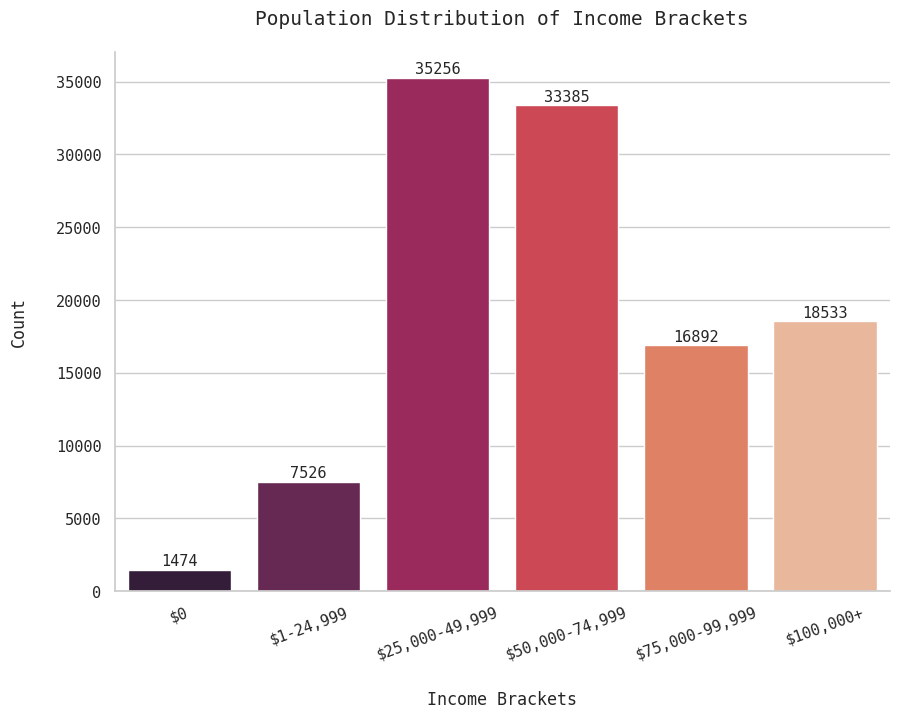

In [75]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'font.size': 11, 'axes.titlesize': 14,
                'axes.titlepad': 20}
sns.set(style='whitegrid', palette='rocket_r', font='monospace', rc=custom_params)
plt.figure(figsize=(10, 7))
sns.countplot(data=loan_charts, x='Income', palette='rocket')
plt.title('Population Distribution of Income Brackets')
plt.xticks(rotation=20)
plt.xlabel('Income Brackets', labelpad=20)
plt.ylabel('Count', labelpad=20)

# Printing values on bars
clarity_counts = loan_charts['Income'].value_counts(sort=False)
for i in range(clarity_counts.shape[0]):
    total = clarity_counts[i]
    plt.text(i, total+1100, total, va='top', ha='center')

#### Income Brackets Insight
There is heavy competition for mode between the 2 middle tier brackets. While the mode does get awarded to 25,000-49,999; it's important to note how even it is. The difference is merely a couple thousand. This relationship carries over to the top 2 income brackets as well. Applicant are more likely to be making 75,000-100,000 than the bottom 2 tiers combined. Prosper loans clearly has a customer base that is influenced by middle-income & higher-income loan conditions. Prosper needs to cater to this demand.

Term
36    87224
60    24228
12     1614
Name: count, dtype: int64


Text(0.5, 1.0, 'Term Distribution in Months')

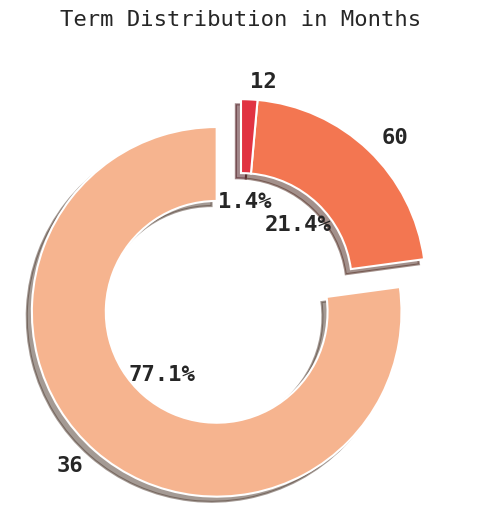

In [76]:
print(loan_charts.Term.value_counts())
labels = ['36', '60', '12']
sizes = [87224, 24228, 1614]
explode = (0.2, 0, 0)
bold_font = FontProperties(weight='bold', size=16)
plt.figure(figsize=(10,6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, 
       wedgeprops={'width':.4, 'linewidth':1.5}, textprops={'fontproperties': bold_font},
       pctdistance=.45)
plt.title('Term Distribution in Months', size=16)

#### Terms Insight
Individuals accepting Loans through Prosper prefer 36 then 60 terms. Hardly any go for the 12 term loan. It's wise to focus on promoting the terms customers are interested in and support these promotions with deals, enticing conditions, etc. Also, increasing 12 month loan terms 18 or 24 should be explored as to increase their popularity.

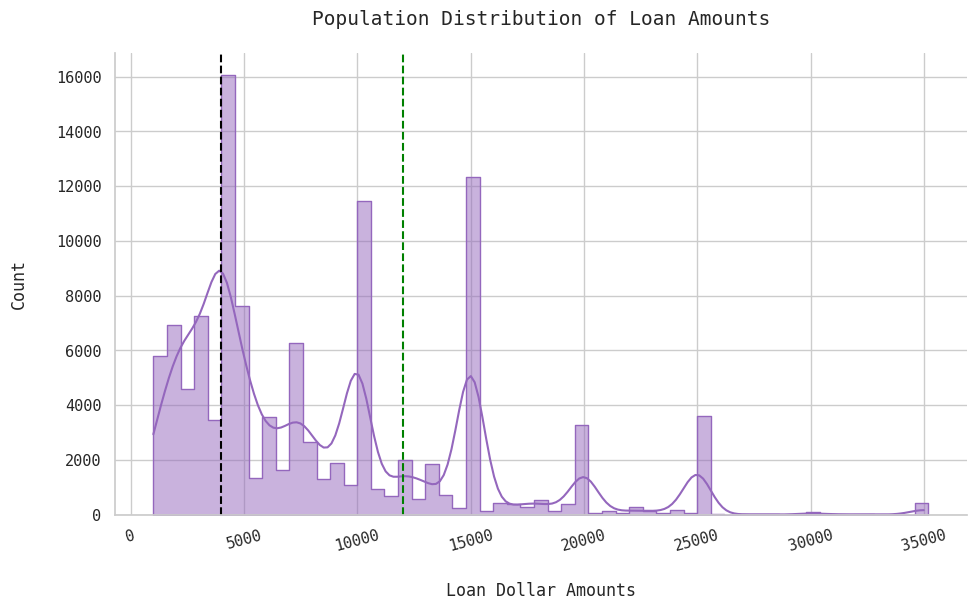

In [77]:
amount_bins = np.arange(1000, 35000+600, 600)
plt.figure(figsize=(11,6))
sns.histplot(data=loan_charts, x='Amount', color='tab:purple', bins=amount_bins, element='step', kde=True)
plt.title('Population Distribution of Loan Amounts')
plt.xticks(rotation=15)
plt.xlabel('Loan Dollar Amounts', labelpad=20)
plt.ylabel('Count', labelpad=20)

q1rt = np.quantile(loan_charts.Amount, .25)
plt.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(loan_charts.Amount, .75)
plt.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

#### Loan Amounts Insight
A bin selection with a step of .01 was chosen to split values on the hundredth decimal place instead of the thousandth. This encourages a more realistic breakdown of the chart as percents are hardly inspected to the thousandth. Past 25,000 loan amount counts steeply drop off. It must be difficult obtaining such a loan. Moreover, there are favorite amounts: 3500-4000, 7500, 10000, 15000, 20000, 25000 remain popular. Prosper should acknowledge this in their marketing campaign to bring in more customers. Focus on these amounts to push sales numbers.

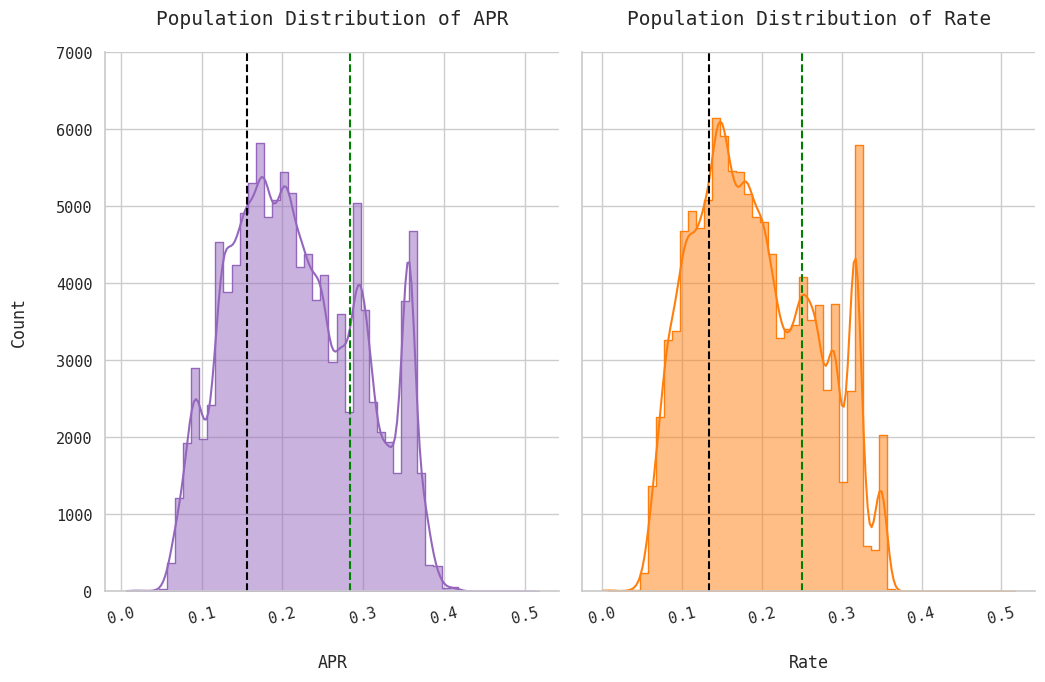

In [78]:
APR_bins = np.arange(.007, .512+.01, .01)
Rate_bins = np.arange(0, .497+.01, .01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Left chart
sns.histplot(data=loan_charts, x='APR', color='tab:purple', element='step', kde=True, bins=APR_bins, ax=ax1)
ax1.set_title('Population Distribution of APR')
ax1.set_xlabel('APR' , labelpad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)
ax1.set_yticks(range(0, 7001, 1000))
ax1.set_ylabel('Count', labelpad=20)

q1rt = np.quantile(loan_charts.APR, .25)
ax1.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(loan_charts.APR, .75)
ax1.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

# Right chart
sns.histplot(data=loan_charts, x='Rate', color='tab:orange', element='step', kde=True, bins=APR_bins, ax=ax2)
ax2.set_title('Population Distribution of Rate')
ax2.set_xlabel('Rate', labelpad=20)
ax2.set(yticklabels=[])
ax2.set_ylabel('')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=15)
ax2.set_yticks(range(0, 7001, 1000))
q1rtR = np.quantile(loan_charts.Rate, .25)
ax2.axvline(x=q1rtR, label='Q1', c='black', linestyle='dashed')
q1rtR3 = np.quantile(loan_charts.Rate, .75)
ax2.axvline(x=q1rtR3, label='Q3', c='green', linestyle='dashed')

plt.subplots_adjust(wspace=.05) 

#### APR Insight
Customer should expect to receive an APR .15 - .35. Most common APRs are .15-.2 & .3 & 3.6. For ideal insight, Prosper should plan financing assuming the average loan borrower will reveive an APR within this range. The further outside the range the more unlikely it becomes for that APR to be provided.
#### Rate Insight
Customer should expect to receive a rate .1 - .325. Most common rates are .125 & .325. For ideal insight, Prosper should plan financing assuming the average loan borrower will reveive a rate within this range. The further outside the range the more unlikely it becomes for that rate to be provided.

### Bivariate Analysis
* Do income brackets favor certain terms over others?
* What is the distribution of each feature per Income Bracket?
* Any noticable APR or Rate benefits when moving up the Income bracket ladder?

Text(0, 0.5, 'Count')

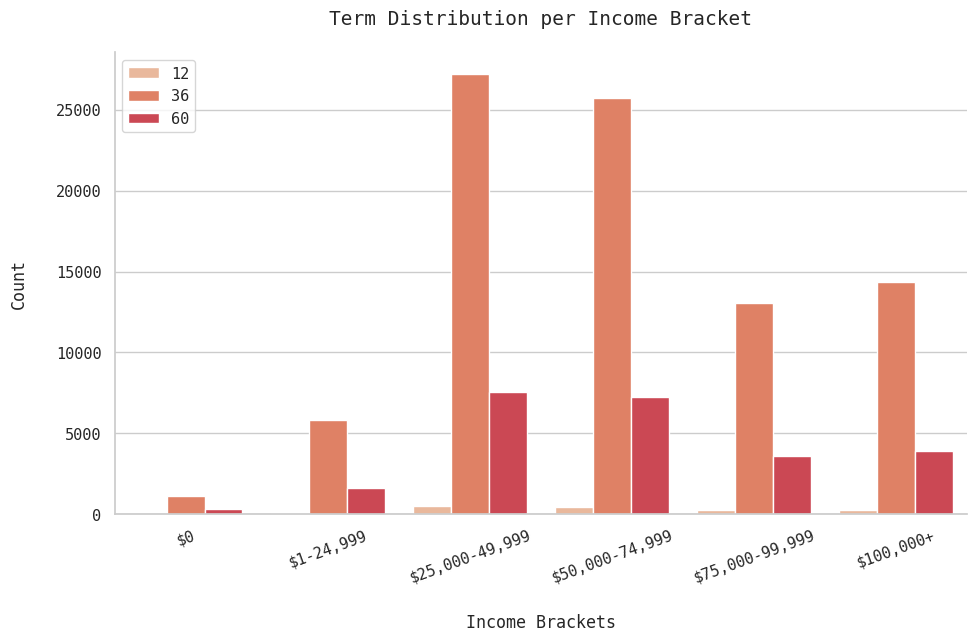

In [79]:
plt.figure(figsize=(11,6))
sns.countplot(data=loan_charts, x='Income', hue='Term')
plt.title('Term Distribution per Income Bracket')
plt.xticks(rotation=20)
plt.xlabel('Income Brackets', labelpad=20)
plt.legend(loc='upper left')
plt.ylabel('Count', labelpad=20)

#### Term x Income Bracket Insight
No matter the income, 36 terms is the gold standard, then 60, then 12. Increasing 12 month loan terms 18 or 24 should be explored as to increase their popularity. 12 months isn't even on the table for customers it seems. An adjust to something closer to 36 would be appreciated and can lead to more loans.

Text(0, 0.5, 'Loan Amount')

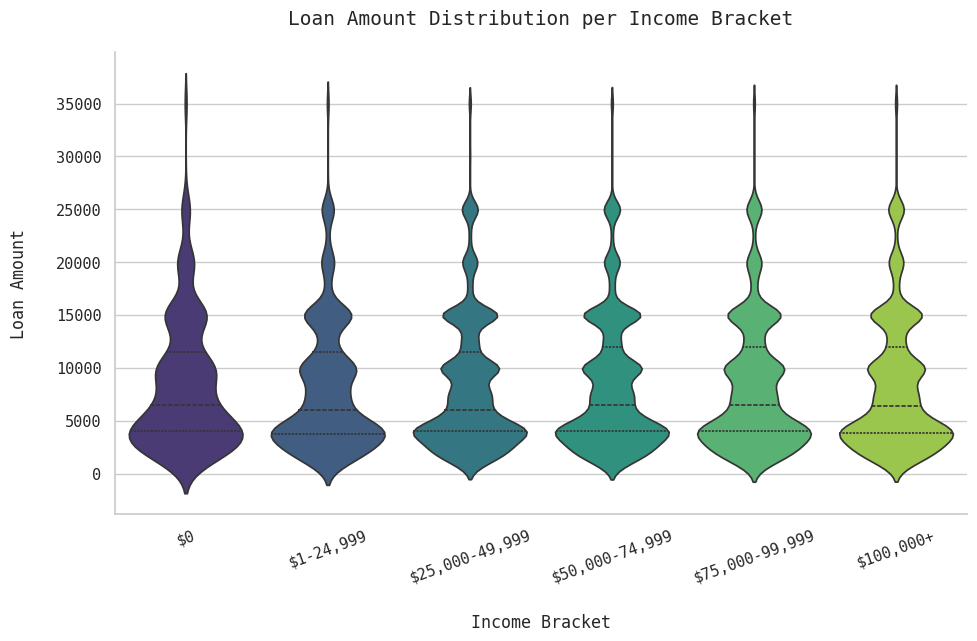

In [80]:
plt.figure(figsize=(11,6))
sns.violinplot(data=loan_charts, x='Income', y='Amount', inner='quartiles', palette='viridis')
plt.xticks(rotation=20)
plt.title('Loan Amount Distribution per Income Bracket')
plt.xlabel('Income Bracket', labelpad=20)
plt.ylabel('Loan Amount', labelpad=20)

#### Loan x Income Bracket Insight
The lowest bracket has a wider distribution range compared to the others. Surprisingly, loan amounts vary very little between categories. Prosper can keep this in mind as targeted loan amounts will receive little payout. Customers of varying incomes can choose either low or high.

Text(0, 0.5, 'APR')

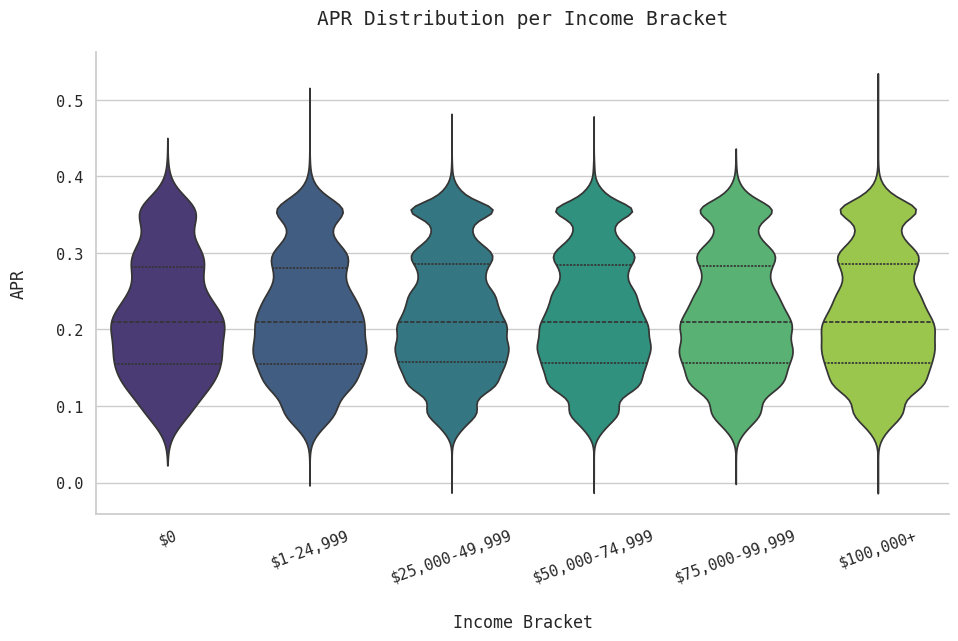

In [81]:
plt.figure(figsize=(11,6))
sns.violinplot(data=loan_charts, x='Income', y='APR', inner='quartiles', palette='viridis')
plt.xticks(rotation=20)
plt.title('APR Distribution per Income Bracket')
plt.xlabel('Income Bracket', labelpad=20)
plt.ylabel('APR', labelpad=20)

#### APR x Income Bracket Insight
Individuals in the highest tier should slighty more expect a higher APR due to their improved financial status. Slightly expected only due to the even distribution across categories. Prosper has better APR flexibilty when customers make more as shown through the 100,000 category.

Text(0, 0.5, 'Rate')

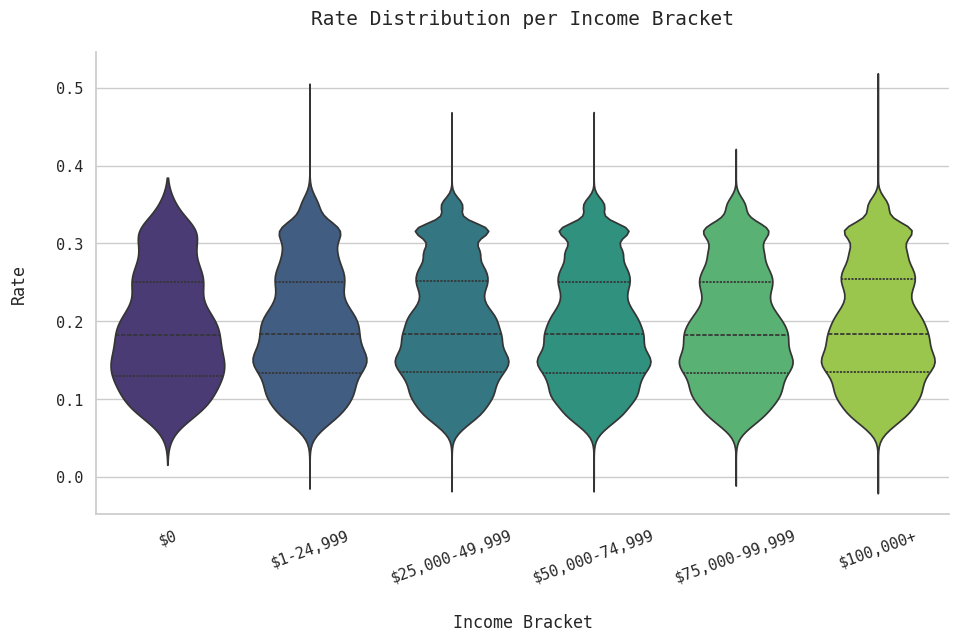

In [82]:
plt.figure(figsize=(11,6))
sns.violinplot(data=loan_charts, x='Income', y='Rate', inner='quartiles', palette='viridis')
plt.xticks(rotation=20)
plt.title('Rate Distribution per Income Bracket')
plt.xlabel('Income Bracket', labelpad=20)
plt.ylabel('Rate', labelpad=20)

#### Rate x Income Bracket Distribution Insight
Individuals in the highest tier should slighty more expect a higher rate due to their improved financial status. Slightly expected only due to the even distribution across categories. Prosper has better rate flexibilty when customers make more as shown through the 100,000 category. Inversly, 0 provides a reliable return of rates from lack of outliers. Like APR, 1-24,999 mimics 100,000 closer than the inbetween categories. Customers in the middle should worry less about receiving an extreme rate.
### Multivariate Analysis
* Are better APRs, rates or higher loan amounts associated to higher income?
* Are APRs & rates determined using similar metrics?
* Do heatmaps or scatterplots show these relationships more effectively?

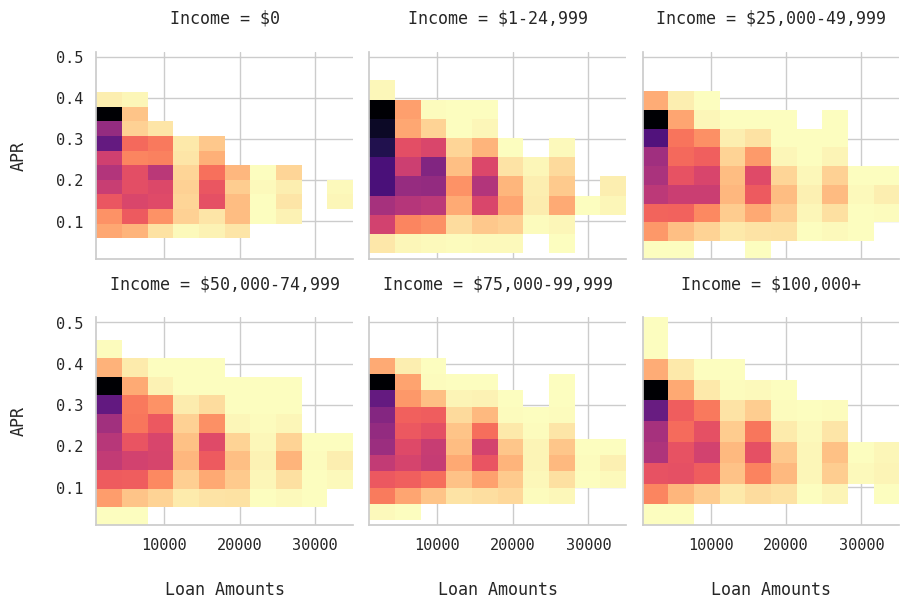

In [83]:
FG = sns.FacetGrid(data=loan_charts, col='Income', col_wrap=3, height=3)
FG.map(plt.hist2d, 'Amount', 'APR', cmap='magma_r', cmin=2, bins=10)
FG.set_xlabels('Loan Amounts', labelpad=20)
FG.set_ylabels('APR', labelpad=20)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Apr x Loan Amounts per Income Insight
1-24,999 has APRs more concetrated than others. This indicates common APRs among customers. Ideally, one should be within the top 4 brackets if they desire to have utmost flexibility with APR. What stands out, in bracket 1-24,999 it is bi-modial distribution, almost multi-modial. Other categories are uni-modial. This relationship is only apparent in the lower amounts section of ~5,000 or less. Income 0 has little outliers. Besides these key differences, the heatmaps are quite similar.

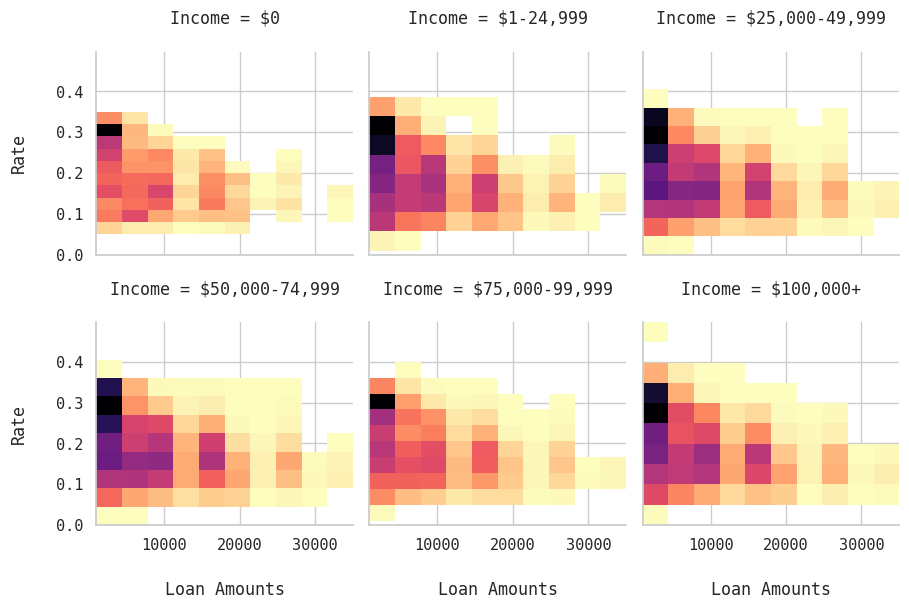

In [84]:
FG = sns.FacetGrid(data=loan_charts, col='Income', col_wrap=3, height=3)
FG.map(plt.hist2d, 'Amount', 'Rate', cmap='magma_r', cmin=2, bins=10)
FG.set_xlabels('Loan Amounts', labelpad=20)
FG.set_ylabels('Rate', labelpad=20)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Rate x Loan Amounts per Income Insight
50,000-74,999 has rates that are more concentrated than others. This indicates common rates among customers. Ideally, one should be within the top 4 brackets if they desire to have utmost flexibility with rate negotiations. 25,000-49,999 & 50,000-74,999 has 3 common rates for lower loan amounts. The others either have 2 or 1. This type of relationship is reflected in loan amounts of 10,000 and 15,000 but with 2 within the mentioned brackets.  Still, brackets besides 0 & 75,000-99,999 are bi-modial. Customers can expect a rate corresponding to the darker cells.

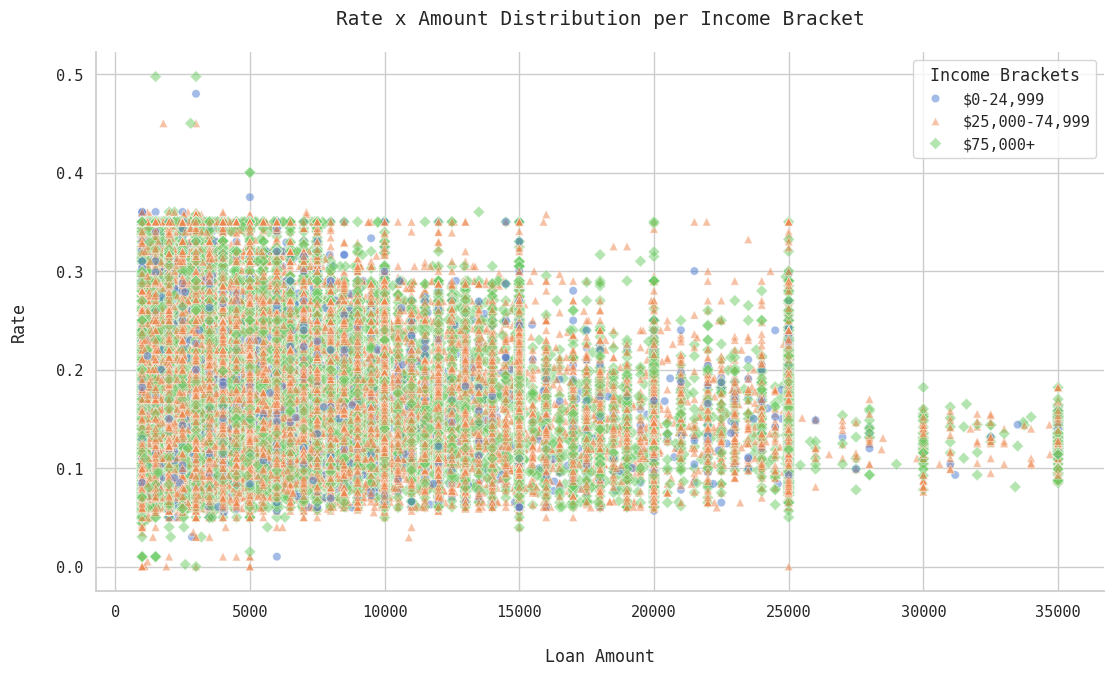

In [85]:
# Ordinal & income grouping lists
inc_order = ['$0-24,999', '$25,000-74,999', '$75,000+']
category_mapping_income = {
    '$0-24,999': ['$0', '$1-24,999'],
    '$25,000-74,999': ['$25,000-49,999', '$50,000-74,999'],
    '$75,000+': ['$75,000-99,999', '$100,000+']
}
marker_styles = {
    '$0-24,999': 'o',
    '$25,000-74,999': '^',
    '$75,000+': 'D'
}

# Income grouping into 3 brackets instead of 6
loan_charts2 = loan_charts.copy()
loan_charts2['Income'] = loan_charts2['Income'].map({income: category for category, incomes in category_mapping_income.items() for income in incomes})
ordinals_IR = pd.CategoricalDtype(categories=inc_order, ordered=True)
loan_charts2['Income'] = loan_charts2['Income'].astype(ordinals_IR)

plt.figure(figsize=(13, 7))
sns.scatterplot(data=loan_charts2, x='Amount', y='Rate', hue='Income', style='Income', alpha=0.5, markers=marker_styles,
               palette='muted')
plt.title('Rate x Amount Distribution per Income Bracket')
plt.xlabel('Loan Amount', labelpad=20)
plt.ylabel('Rate', labelpad=20)
plt.legend(title='Income Brackets')

#### Rate x Loan Amount per Income Bracket Insight
Chart readibility was at an all time low with 5 income brackets. Looked like a glob of rainbow goo. To rectify, income brackets were grouped into pairs of 3 instead of individual 6. This chart provides evidence for minimum & maximum loan amounts being accessible to any income bracket. On the contrary, distribution is mixed. 25,000-75000+ tiers are readily given loans of 25000+, where the lowest tier generally has access lower than 25,000. It also appears rate is not affixed to income bracket, given the wide and uniform distribution of each income bracket. Prosper needs to limit access of higher loans to 0-24,999 more. There shouldn't be any customer of that stature acquitted with a loan they can't pay back.

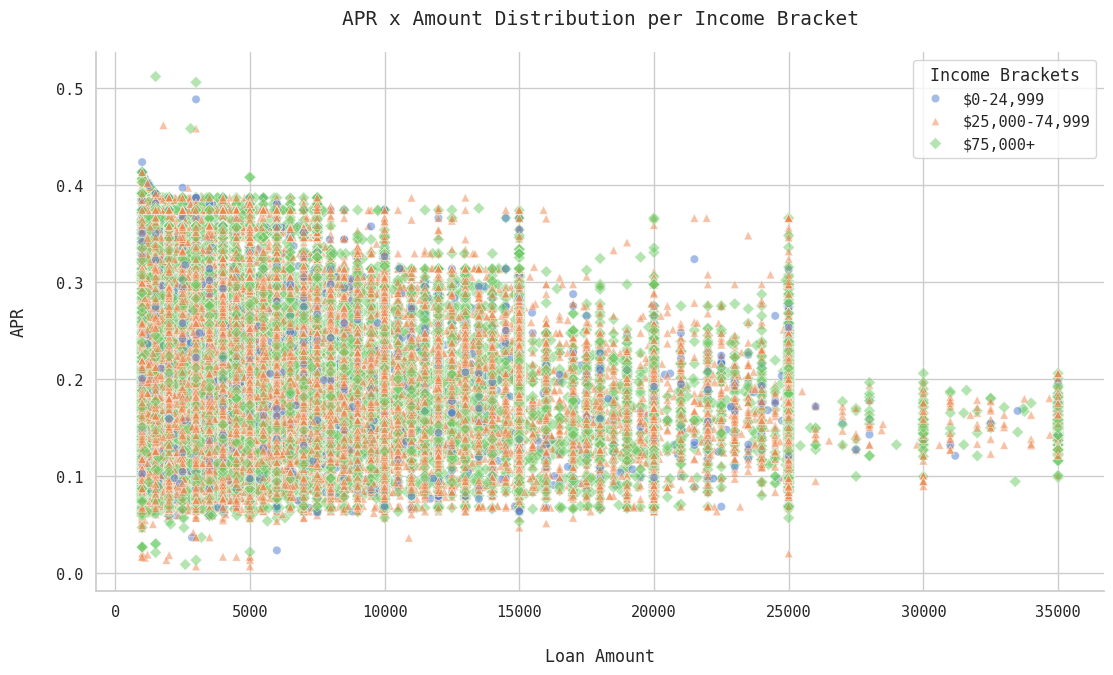

In [86]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=loan_charts2, x='Amount', y='APR', hue='Income', style='Income', alpha=0.5, markers=marker_styles,
               palette='muted')
plt.title('APR x Amount Distribution per Income Bracket')
plt.xlabel('Loan Amount', labelpad=20)
plt.ylabel('APR', labelpad=20)
plt.legend(title='Income Brackets')
plt.show()

#### APR x Loan Amount per Income Bracket Insight
The differences between this chart and the previous are extremely minimal. Prosper has a mirrored system when assigning APRs & Rates. Distribution, min, and max are practically identical. Customer should be prepard to woo Prosper into providing a lower APR or rate based on other factors, such as credit instead of their income status



## *Research Question #2*
#### *Do certain occupations receive better loan conditions over others? Are term lengths evenly distributed?*

In [87]:
occ_charts = loan_df[['Term', 'LoanOriginalAmount', 'BorrowerAPR', 'BorrowerRate']].copy()
occ_charts = occ_charts.rename(columns={'LoanOriginalAmount':'Loan Amount', 'BorrowerAPR':'APR', 'BorrowerRate':'Rate'})
occ_charts['Occupation'] = customer_ML['Occupation'].copy()
occ_charts

Term  Loan Amount    APR   Rate                Occupation
0         36         9425  0.165  0.158                     Other
1         36        10000  0.120  0.092              Professional
2         36         3001  0.283  0.275             Skilled Labor
3         36        10000  0.125  0.097                 Executive
4         36        15000  0.246  0.208              Professional
...      ...          ...    ...    ...                       ...
113061    36        10000  0.224  0.186  Administrative Assistant
113062    36         2000  0.132  0.111                     Other
113063    60        10000  0.240  0.215                     Other
113064    60        15000  0.284  0.261                     Other
113065    36         2000  0.132  0.104                     Other

[113066 rows x 5 columns]

In [88]:
occ_charts.Occupation.value_counts()

Occupation
Other                          31951
Professional                   13531
Computer Programmer             4442
Executive                       4280
Teacher                         3729
                               ...  
Dentist                           67
Student - College Freshman        41
Student - Community College       28
Judge                             22
Student - Technical School        16
Name: count, Length: 67, dtype: int64

#### Feature Engineering
Occupations will be grouped into relative categories to provide better insight on graphs and reduce clutter, given the wide array of occupations listed.

In [89]:
category_mapping = {
    'Management & Leadership': ['Executive', 'Retail Management', 'Food Service Management', 'Police Officer/Correction Officer', 
                                  'Military Officer', 'Principal', 'Judge'],
    'Skilled Trades': ['Skilled Labor', 'Construction', 'Tradesman - Mechanic', 'Tradesman - Electrician', 'Tradesman - Carpenter', 'Tradesman - Plumber'],
    'Sales & Marketing': ['Sales - Retail', 'Sales - Commission', 'Realtor', 'Car Dealer'],
    'Hospitality & Service': ['Food Service', 'Waiter/Waitress', 'Flight Attendant', 'Bus Driver', 'Religious'],
    'Healthcare & Nursing': ['Nurse (RN)', 'Nurse (LPN)', 'Nurse\'s Aide', 'Pharmacist', 'Doctor', 'Dentist'],
    'Education': ['Teacher', 'Professor', 'Teacher\'s Aide', 'Student - College Senior', 'Student - College Graduate Student', 'Student - College Sophomore', 
                  'Student - College Junior', 'Student - College Freshman', 'Student - Community College', 'Student - Technical School'],
    'Legal & Financial': ['Accountant/CPA', 'Attorney'],
    'Engineering & Tech': ['Computer Programmer', 'Engineer - Mechanical', 'Engineer - Electrical', 'Engineer - Chemical'],
    'Science': ['Scientist', 'Biologist', 'Chemist'],
    'Public Service': ['Fireman', 'Civil Service', 'Postal Service', 'Social Worker', 'Military'],
    'Office Workers': ['Clerical', 'Clergy', 'Analyst', 'Investor', 'Psychologist'],
    'Creative & Arts': ['Architect', 'Landscaping', 'Homemaker'],
    'Transportation & Logistics': ['Truck Driver', 'Pilot - Private/Commercial'],
    'Other': ['Other'],
    'Professional': ['Professional']
}
occ_charts['Occupation'] = occ_charts['Occupation'].map({occupation: category for category, occupations in category_mapping.items() for occupation in occupations})
print(occ_charts.shape)
occ_charts.Occupation.value_counts()

(113066, 5)


Occupation
Other                         31951
Professional                  13531
Management & Leadership       10317
Office Workers                 7264
Engineering & Tech             7179
Sales & Marketing              6906
Skilled Trades                 6132
Education                      5257
Healthcare & Nursing           4267
Legal & Financial              4242
Public Service                 3221
Hospitality & Service          2109
Transportation & Logistics     1864
Science                         636
Creative & Arts                 565
Name: count, dtype: int64

#### Feature breakdown
Term is ordinal quantitative. Ocucpation is nominal quantitative. Due to its status as independent variable for the research question, charts will be categorized based on Occupation. Rate, APR, and Amount are continuous variables while Term is individually discrete, all dependent. 
### Univariate Analysis
* Population distributions for the qualitative features: Occupaton & Term
* Is there an outstanding difference between the mode category and the min category?
* Unimodal, bimodal or multimodal?

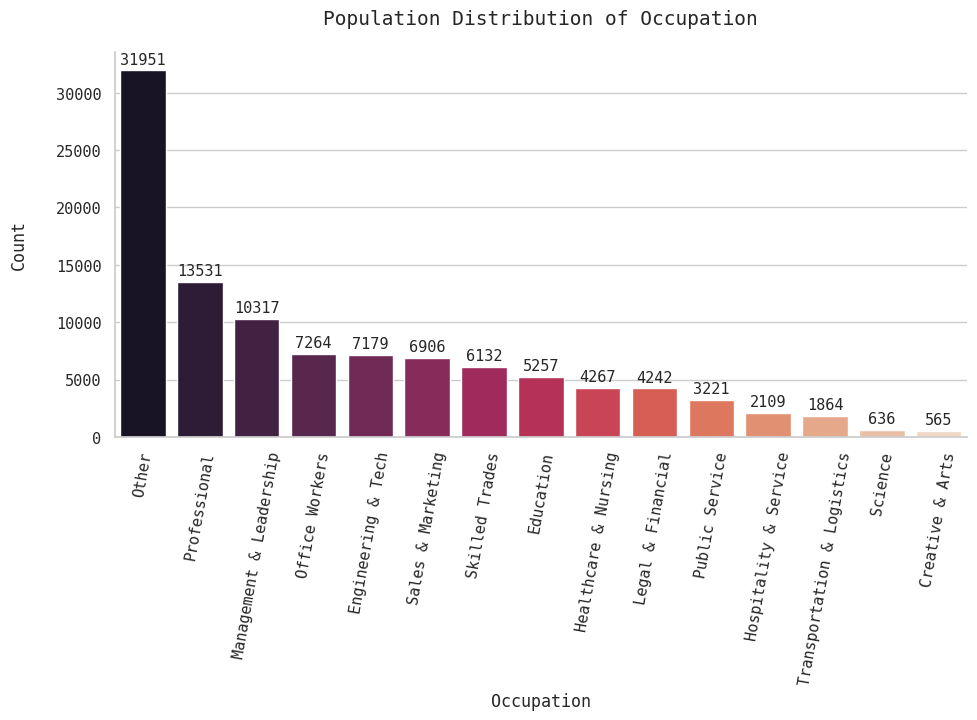

In [90]:
# Pre-chart setup
term_order2 = [12, 36, 60]
terms2 = pd.CategoricalDtype(categories=term_order, ordered=True)
occ_charts['Term'] = loan_charts['Term'].astype(terms)

popXocc = occ_charts.Occupation.value_counts().index
plt.figure(figsize=(11,5))
sns.countplot(data=occ_charts, x='Occupation', palette='rocket', order=popXocc)
plt.xticks(rotation=80)
plt.title('Population Distribution of Occupation')
plt.ylabel('Count', labelpad=20)

# Printing values on bars
clarity_counts = occ_charts['Occupation'].value_counts()
for i in range(clarity_counts.shape[0]):
    total = clarity_counts[i]
    plt.text(i, total+1600, total, va='top', ha='center')

#### Occupation Insight
Other is by far the mode, but this is presumably due to it's vast reach across the job sphere. Sadly the information behind what makes up Other is vacant. Diving deeper into that category would be insightful but I digress. Creative & Arts and Science are barely noticable in the back. Prosper could consider making marketing attempts to these groups for easy growth unless there's an absence of workers available. An alternative and proven effective approach is targeting Professional to Legal & Financial categories. Word spreads easily since employees are in close proximity, in other words free advertising.

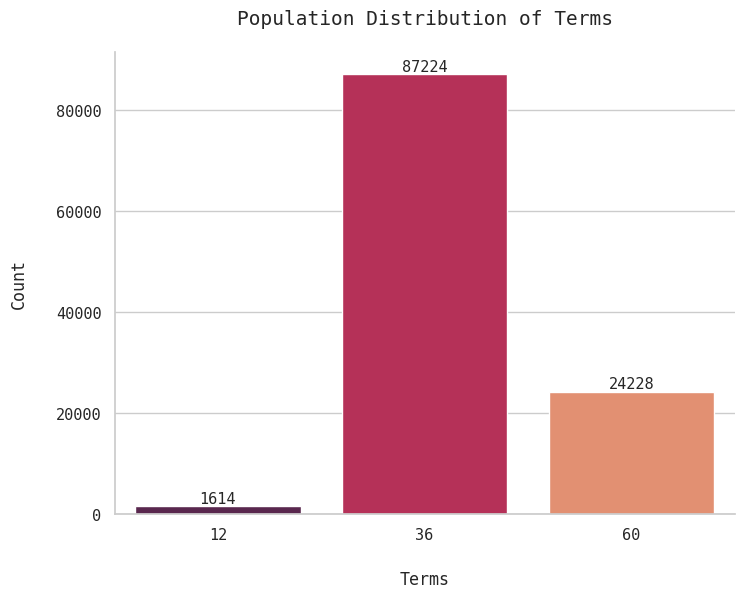

In [91]:
plt.figure(figsize=(8, 6))
sns.countplot(data=occ_charts, x='Term', palette='rocket')
plt.title('Population Distribution of Terms')
plt.xlabel('Terms', labelpad=20)
plt.ylabel('Count', labelpad=20)

# Printing values on bars
clarity_counts = occ_charts['Term'].value_counts(sort=False)
for i in range(clarity_counts.shape[0]):
    total = clarity_counts.iloc[i]
    plt.text(i, total+3000, total, va='top', ha='center')

#### Terms Insight
Individuals accepting Loans through Prosper prefer 36 then 60 terms. Hardly any go for the 12 term loan. It's wise to focus on promoting the terms customers are interested in and support these promotions with deals, enticing conditions, etc. Additionally, increasing 12 month loan terms 18 or 24 should be explored as to increase their popularity.

### Bivariate Analysis
* Do certain professions land people in positions to take out higher amount loans?
* Are any categories able to pull in more people obtaining a specific loan amount compared to Other?
* Which occupations have the highest value outliers for loan amounts?

Text(0.5, 1.0, 'Loan Amount Distribution per Occupation')

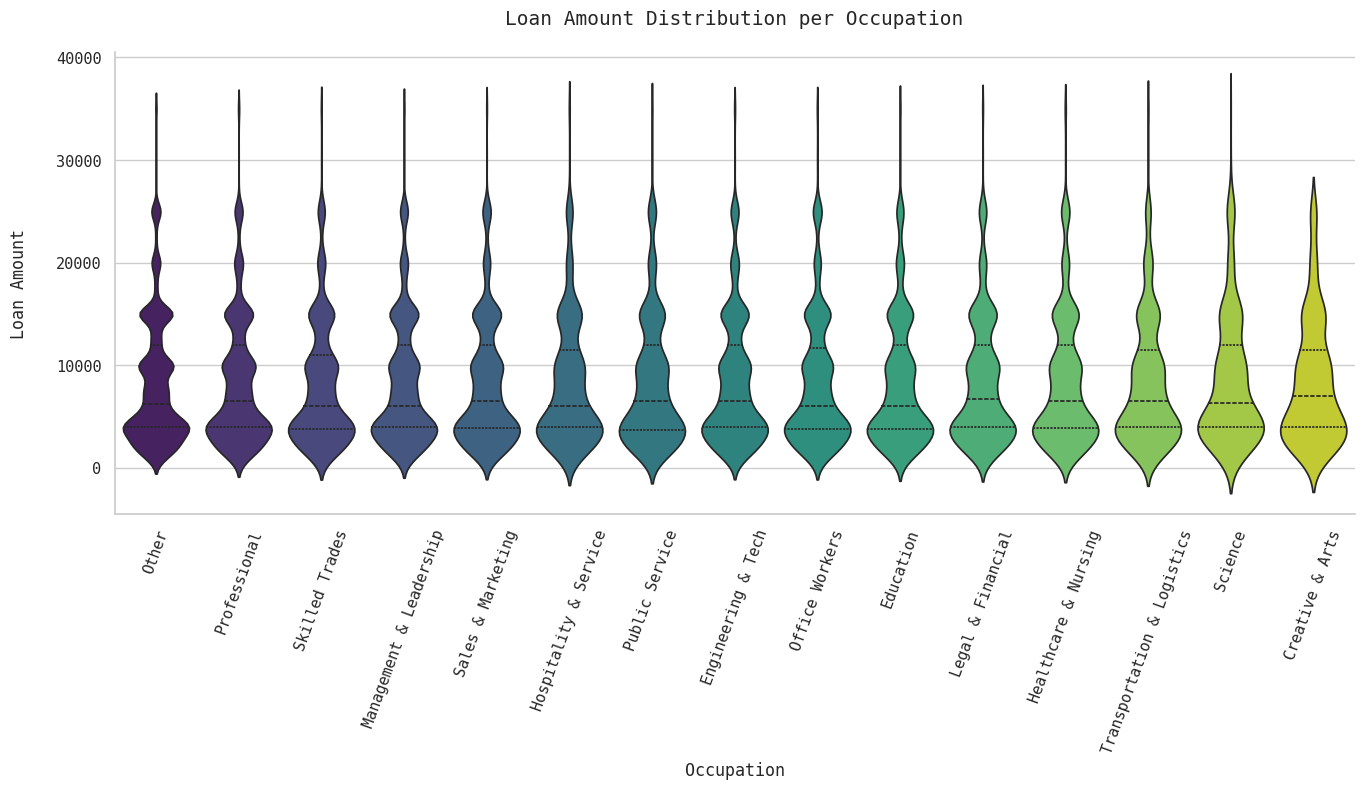

In [92]:
plt.figure(figsize=(16,6))
sns.violinplot(data=occ_charts, x='Occupation', y='Loan Amount', inner='quartiles', palette='viridis')
plt.xticks(rotation=70)
plt.ylabel('Loan Amount', labelpad=20)
plt.title('Loan Amount Distribution per Occupation')

#### Loan Amount x Occupation Insight
Due to their limited population or restricted financing, Creative & Arts has the strictest range for loan amounts available. Science and Hospitality & Service have the highest loan amounts recorded. Prosper can pursue this and secure higher loans within these occupations. Quartile ranges are similar showing how loan amounts or minimally correlated occupations. Other variables will likely be heavier influences, such as credit status. However, with the bottom quartile having such volume in all categories, Prosper needs to explore ways into enticing these lower loan amount borrowers into higher loans. If such an advertising strategy succeeds, profits will rise.
### Multivariate Analysis
* Does APR/rate and loan fluctuate between Occupations?
* Does Term lengths get a bonus of lower APR/rates?
* Are any terms able to secure higher loans?

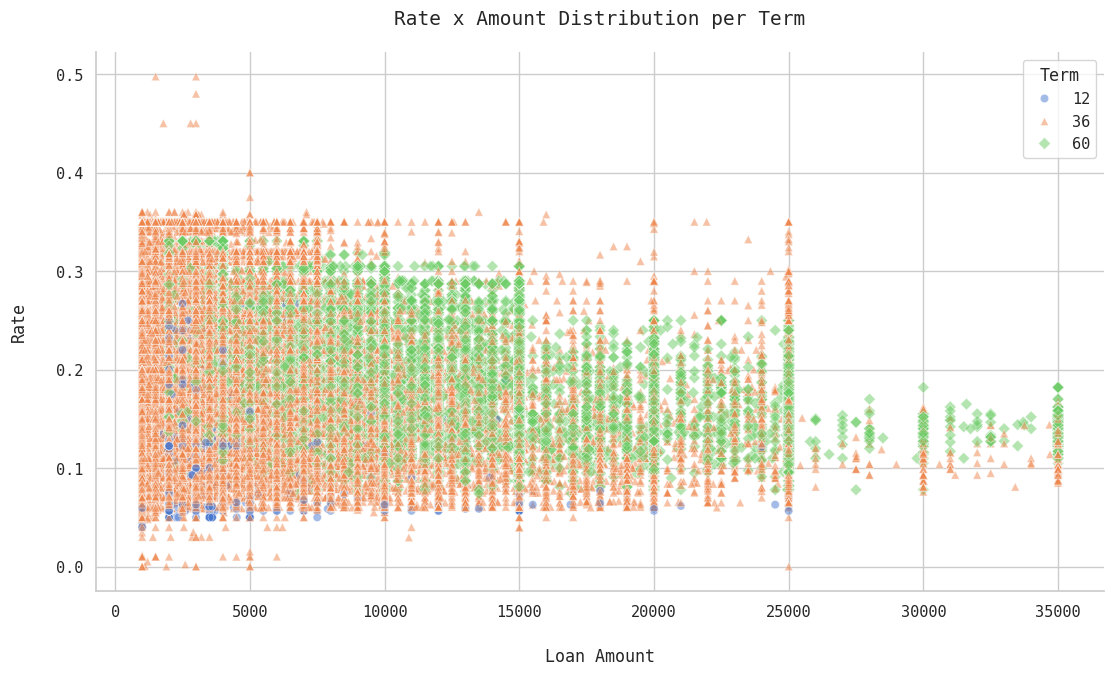

In [93]:
plt.figure(figsize=(13, 7))
marker_styles = {
    12: 'o',
    36: '^',
    60: 'D'
}
sns.scatterplot(data=loan_charts, x='Amount', y='Rate', hue='Term', style='Term', alpha=0.5, markers=marker_styles,
               palette='muted')
plt.title('Rate x Amount Distribution per Term')
plt.xlabel('Loan Amount', labelpad=20)
plt.ylabel('Rate', labelpad=20)
plt.legend(title='Term')
plt.show()

#### Rate x Loan Amount per Term InsightCustomers who select 36 or 60 terms are provided maximum flexibility. They can choose to as high as the max (35000) or the minimum (1000). If someone values having amount options on the table, then one of these categories needs to be picked. Additionally, rate shows none or minimal correlation to Term; given the similar vertical height of each Term. The key difference is Term 36 reaching up to .5 rate values. Higher loan amounts hover between 0.1 - 0.2 rate exclusively.


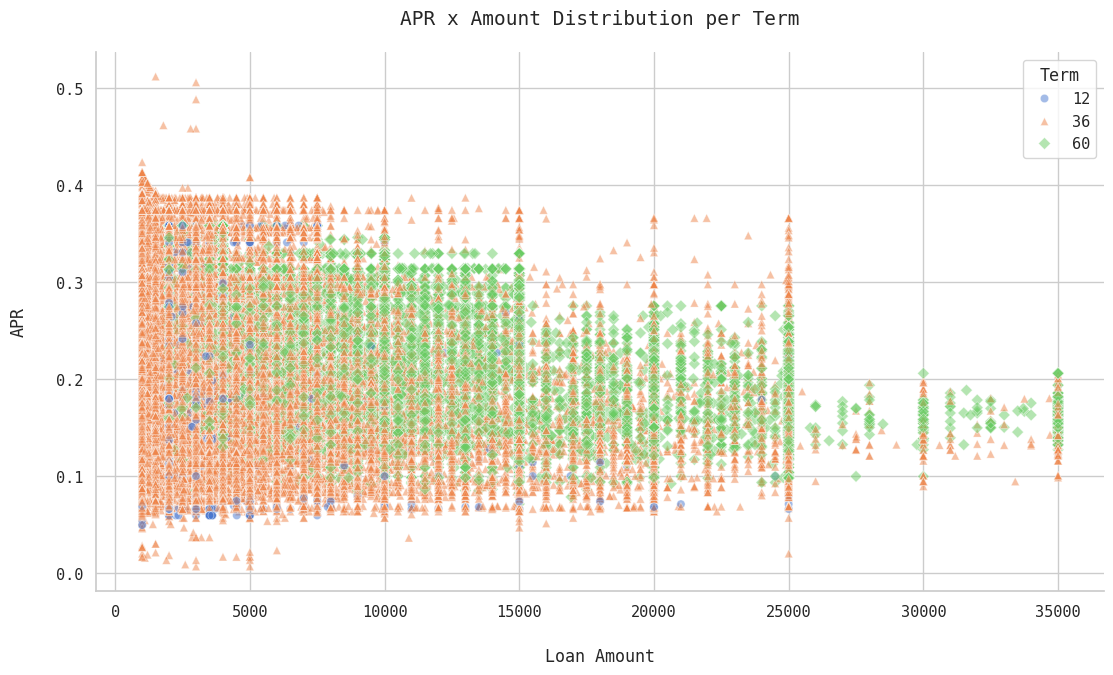

In [94]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=loan_charts, x='Amount', y='APR', hue='Term', style='Term', alpha=0.5, markers=marker_styles,
               palette='muted')
plt.title('APR x Amount Distribution per Term')
plt.xlabel('Loan Amount', labelpad=20)
plt.ylabel('APR', labelpad=20)
plt.legend(title='Term')
plt.show()

#### APR x Loan Amount per Term Insight
Customers who select 36 or 60 terms are provided maximum flexibility. They can choose to as high as the max (35000) or the minimum (1000). If someone values having amount options on the table, then one of these categories needs to be picked. Additionally, rate shows none or minimal correlation to Term; given the similar vertical height of each Term. The key difference is Term 36 reaching up to .5 rate values. Higher loan amounts hover between 0.1 - 0.2 APR exclusively.

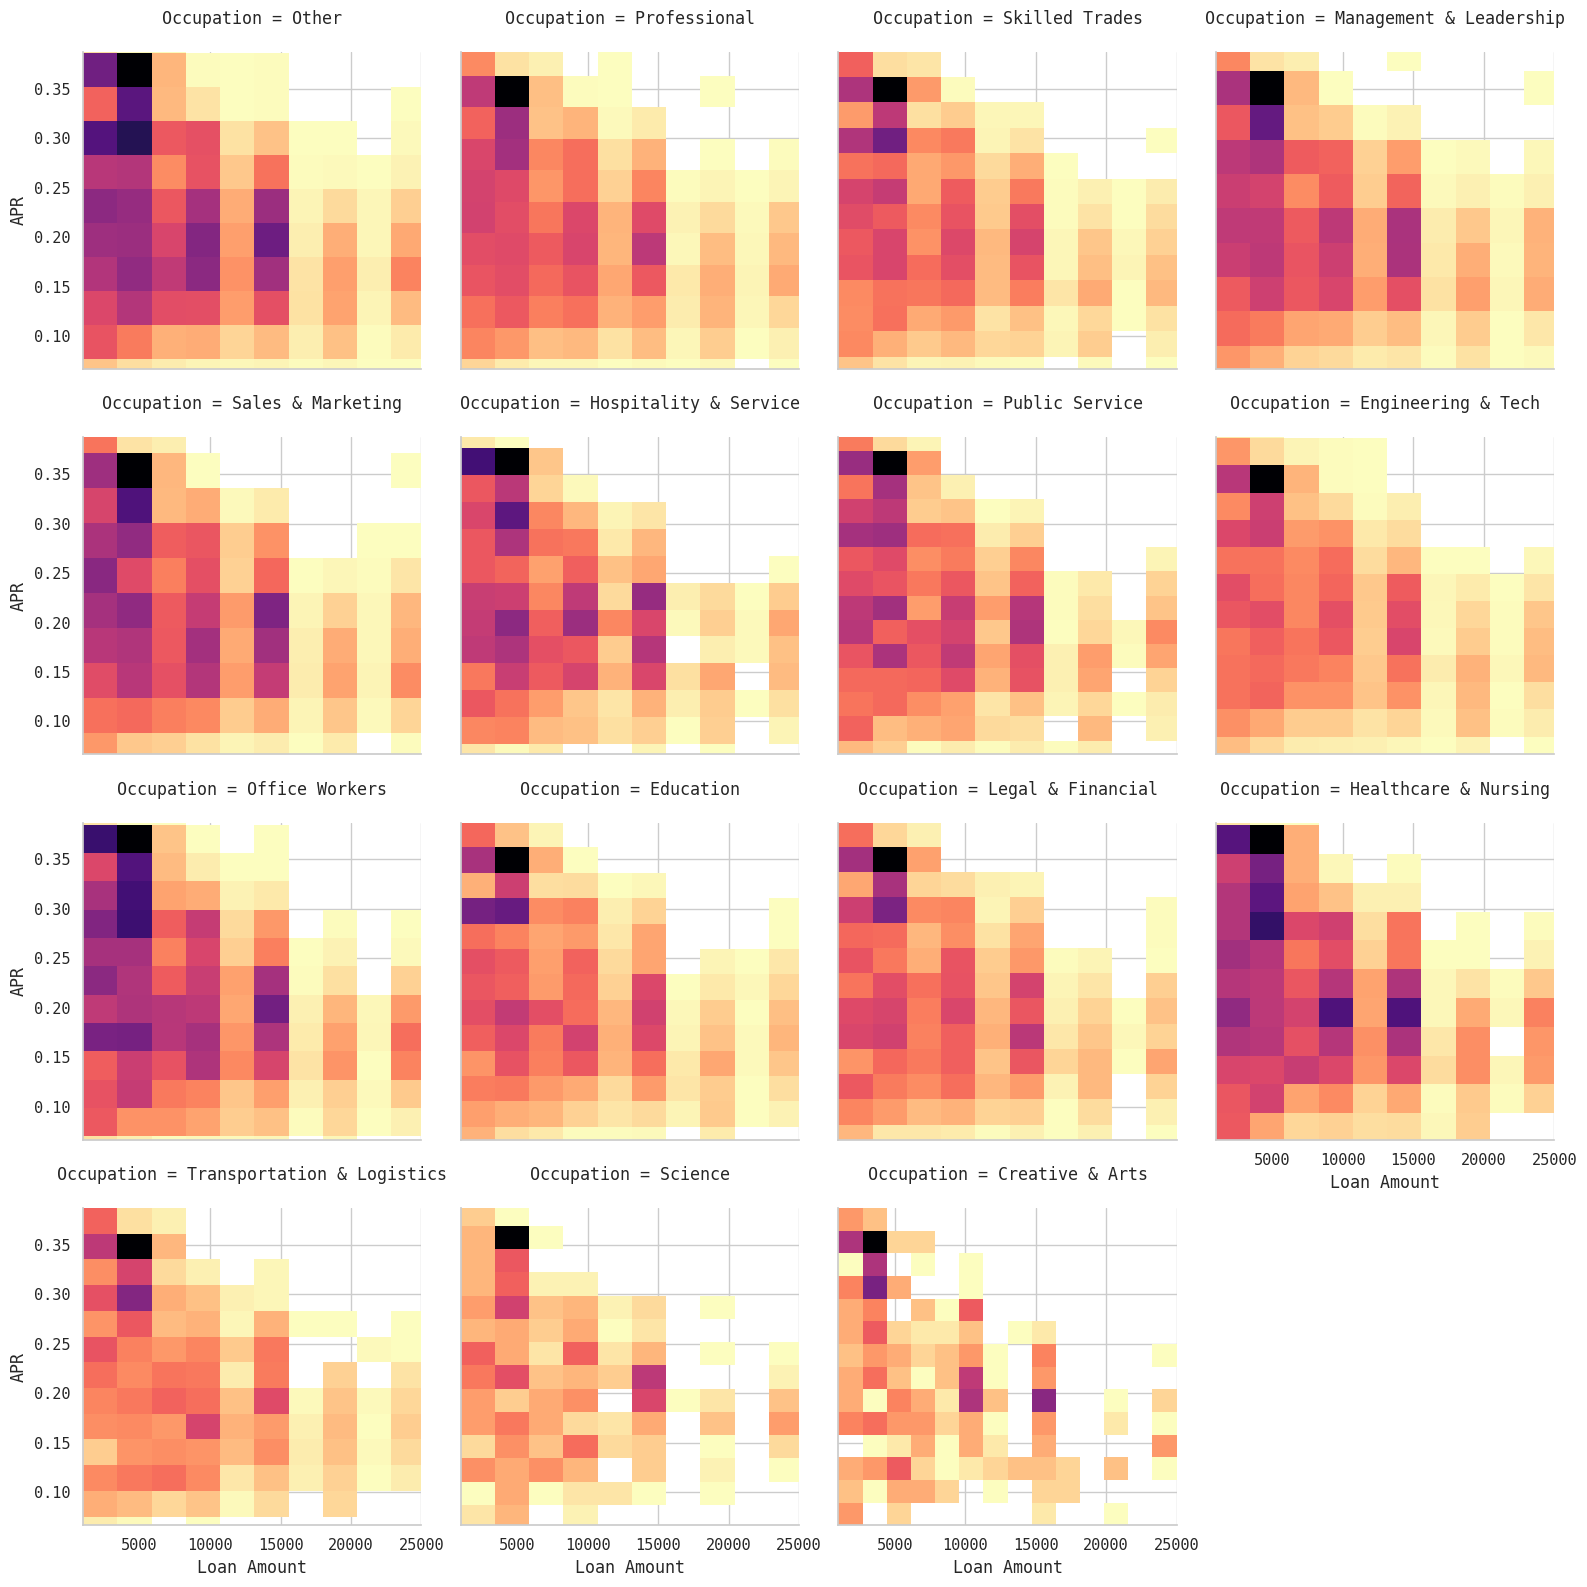

In [95]:
FG = sns.FacetGrid(data=occ_charts, col='Occupation', col_wrap=4, height=4)
FG.map(plt.hist2d, 'Loan Amount', 'APR', cmap='magma_r', cmin=2, bins=14)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Loan Amount x APR per Occupation Insight
Healthcare & Nursing, Office Workers, Other, Sales & Marketing, Management & Leadership have similar distributions for .15 - .35 APR. These color density findings are probably related to their population counts. The similarities span across all occupations in regards to the most common APR and loan of .35 | 5,000. Generally APRs of around .3 are provided for lower amounts. Higher amounts such as 10,000+ receive a beneficial APR drop to around .2; with 25,000+ hovering around .15. Prosper is doing a swell job staying competitive with rates for the bigger loans as shown by the white cells in the top right corner of each subplot.

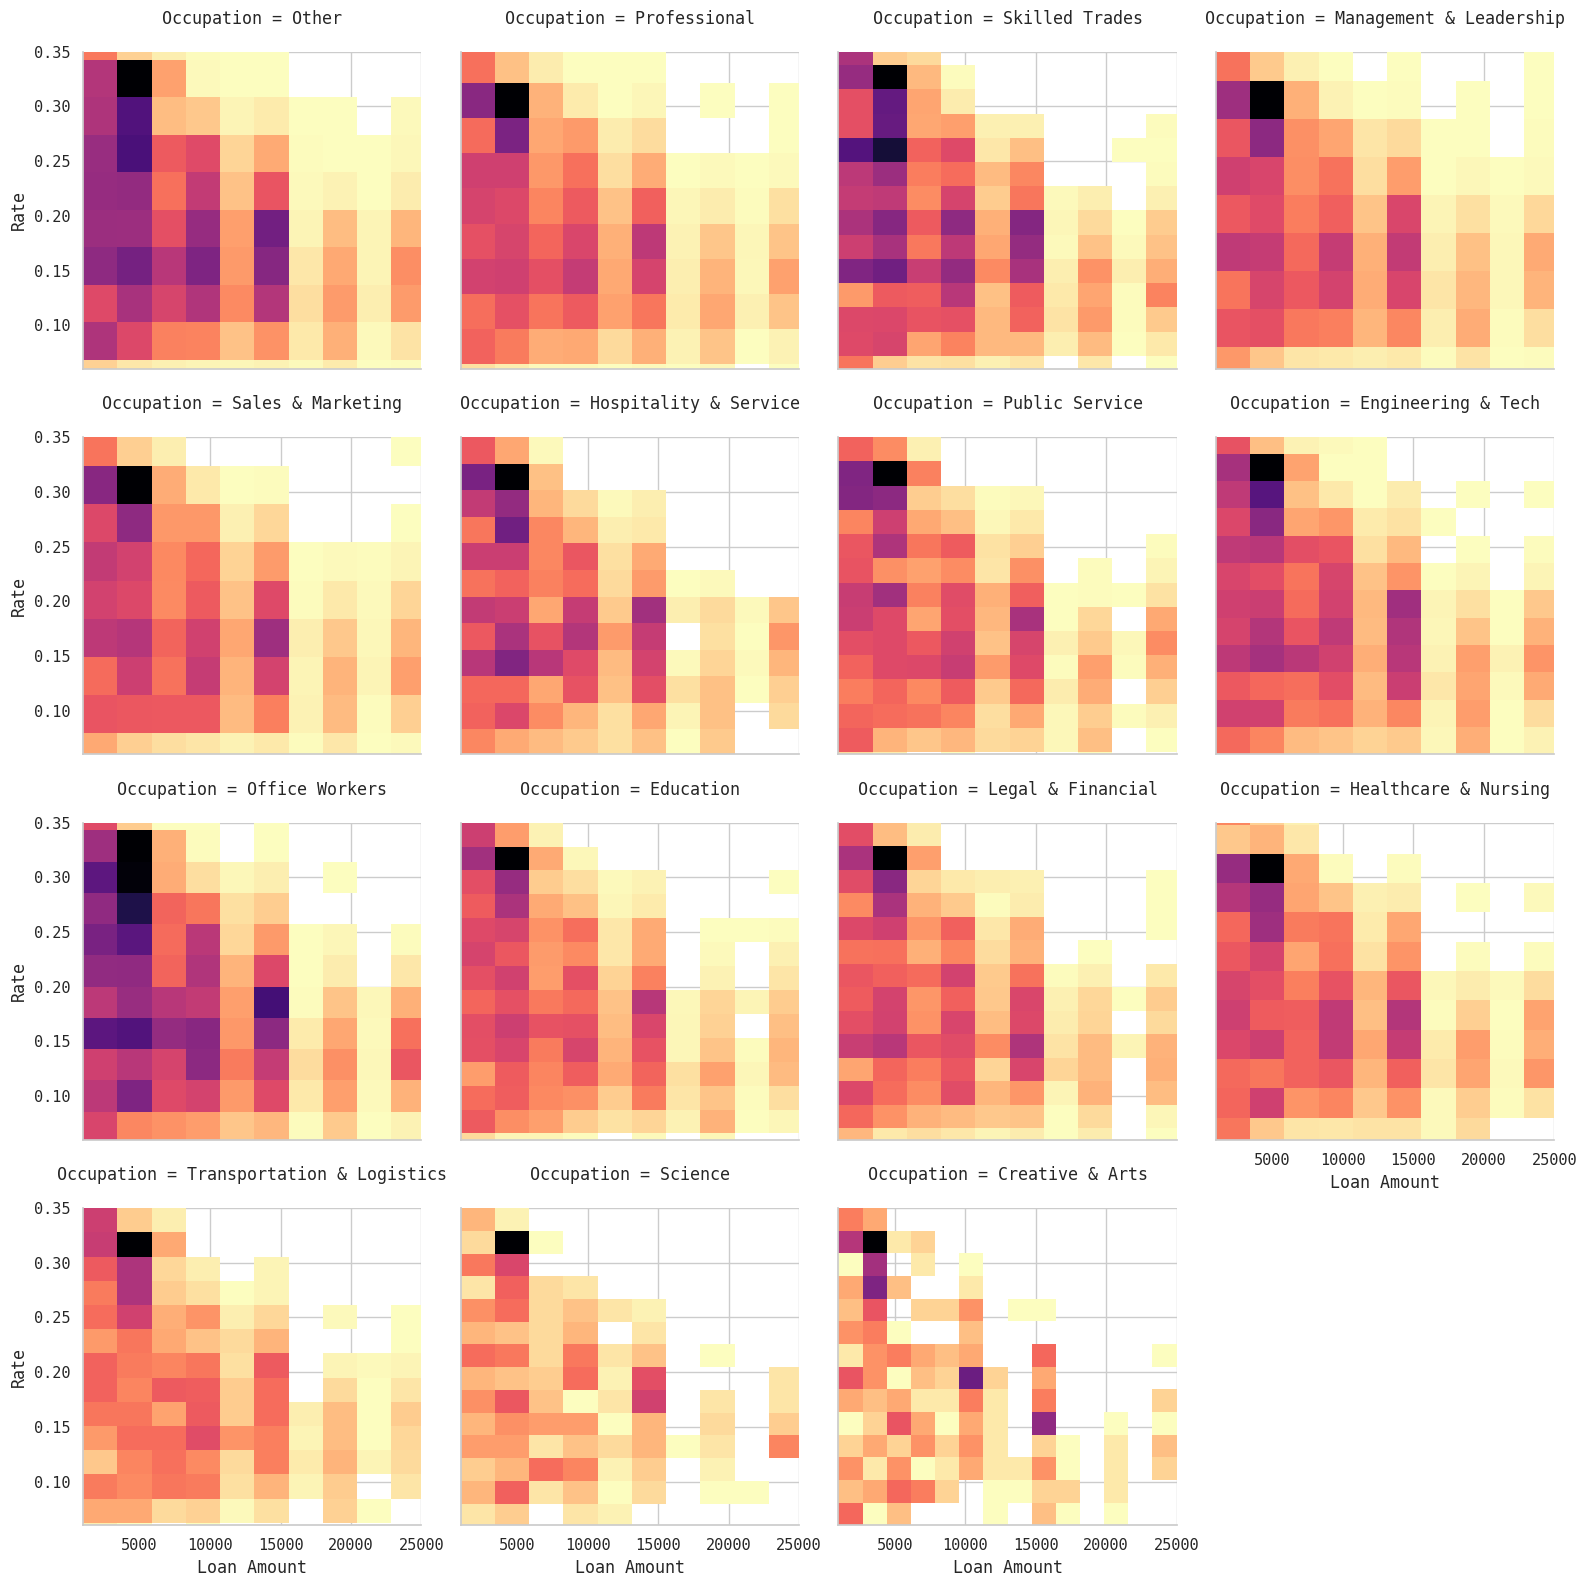

In [96]:
FG = sns.FacetGrid(data=occ_charts, col='Occupation', col_wrap=4, height=4)
FG.map(plt.hist2d, 'Loan Amount', 'Rate', cmap='magma_r', cmin=2, bins=14)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Loan Amount x Rate per Occupation Insight
Healthcare & Nursing, Office Workers, Other, Sales & Marketing, Management & Leadership have similar distributions for .15 - .35 APR. Office Workers have common Rates among it's customers considering it bimodial, almost multimodial status. Includes 8 darker colored cells. Skilled Trades also has a bimodial setup with 6 darker cells. Rates for these 2 categories be more shared compared to other categories. The similarities span across all occupations in regards to the most common rate and loan of .35 | 5,000. Generally rates of around .3 are provided for lower amounts. Higher amounts such as 10,000+ receive a beneficial rate drop to around .2; with 25,000+ hovering around .15. Prosper is doing a swell job staying competitive with rates for the bigger loans as shown by the white cells in the top right corner of each subplot.

## *Research Question #3*
#### *Are there variables that constitute a higher Prosper Score?*

In [100]:
score_charts = customer_ML[['ProsperScore', 'IncomeVerifiable', 'TotalTrades']].copy()
score_charts[['OpenCreditLines',
              'CurrentDelinquents', 'AmountDelinquent', 'CreditScore']] = credit_df[['OpenCreditLines', 'CurrentDelinquencies',
                                                                                    'AmountDelinquent', 'CreditScore']].copy()

# Rounding feature values to whole numbers due to decimal insignificance and for discreet formatting
def column_rounder(col):
    score_charts[col] = score_charts[col].round(0)
    return score_charts

for col in score_charts.columns:
    score_charts = column_rounder(col)

# 1.0 is Yes, 0 is No
print(score_charts.IncomeVerifiable.value_counts())
score_charts.head(5)

# Ordering ProsperScore
scores_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
PS_order = pd.CategoricalDtype(ordered=True, categories=scores_list)
score_charts['ProsperScore'] = score_charts['ProsperScore'].astype(PS_order)

IncomeVerifiable
1.0    104479
0.0      8587
Name: count, dtype: int64


In [101]:
score_charts.loc[score_charts['IncomeVerifiable'] == 1, 'IncomeVerifiable'] = "Yes"
score_charts.loc[score_charts['IncomeVerifiable'] == 0, 'IncomeVerifiable' ] = "No"
print(score_charts.IncomeVerifiable.value_counts())

IncomeVerifiable
Yes    104479
No       8587
Name: count, dtype: int64


### Univariate Analysis
* Which ProsperScores are easist & hardest to obtain? Which type of mode?
* Is IncomeVerifiable a "Yes" value for majority of customers?
* How many open credit lines are average? What are the max range outliers?

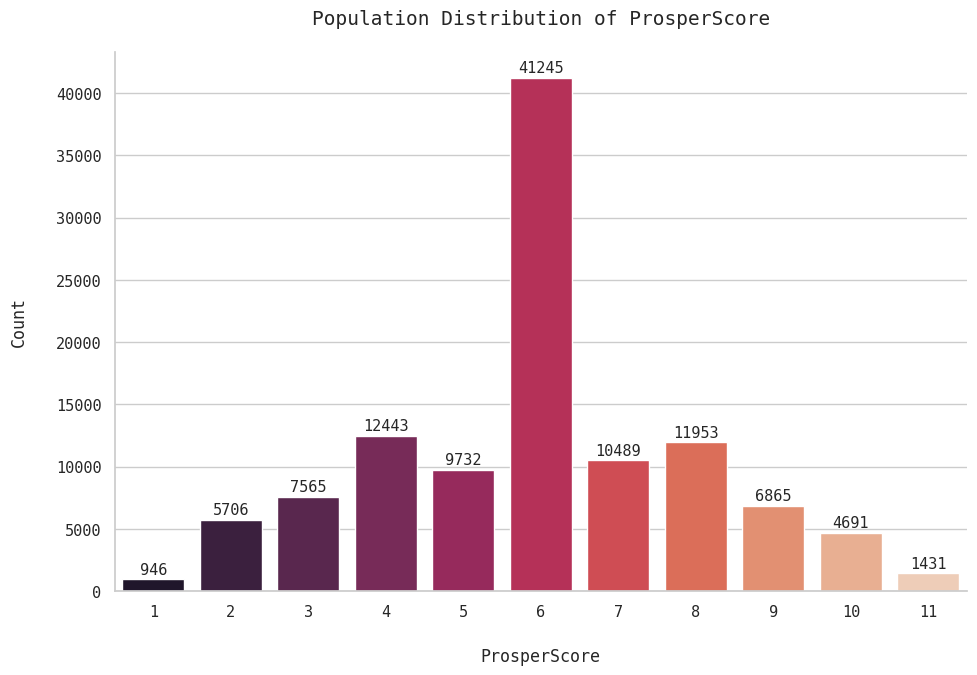

In [102]:
plt.figure(figsize=(11,7))
sns.countplot(data=score_charts, x='ProsperScore', palette='rocket')
plt.title('Population Distribution of ProsperScore')
plt.ylabel('Count', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

# Printing values on bars
clarity_counts = score_charts['ProsperScore'].value_counts(sort=False)
for i in range(clarity_counts.shape[0]):
    total = clarity_counts.iloc[i]
    plt.text(i, total+1400, total, va='top', ha='center')

#### ProsperScore Insight
The middle tiers of 4, 6, and 8 contain most records. Leading by 6 due to the mean impute that was enacted on null values. It's equally difficult to achieve a high ProsperScore and a low. Customers should aim for a 6 or above to be considered average or above average.

Text(0.5, 1.0, 'Income Verifiable Distribution')

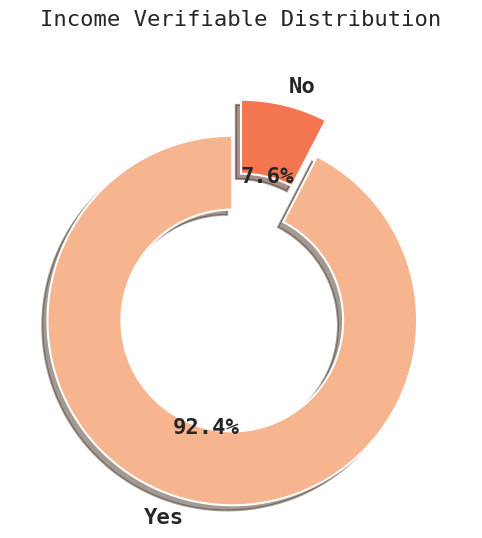

In [103]:
labels = ['Yes', 'No']
sizes = [104479, 8587]
explode = (0.2, 0)
bold_font = FontProperties(weight='bold', size=16)
plt.figure(figsize=(10,6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, 
       wedgeprops={'width':.4, 'linewidth':1.5}, textprops={'fontproperties': bold_font})
plt.title('Income Verifiable Distribution', size=16)

#### Income Verifiable Insight
Loans are easier to obtain when financial status is verified. This enables Prosper to deal offers or loan conditions in confidence. Efforts by both parties should be done to reduce the "No" 7.6% figure.

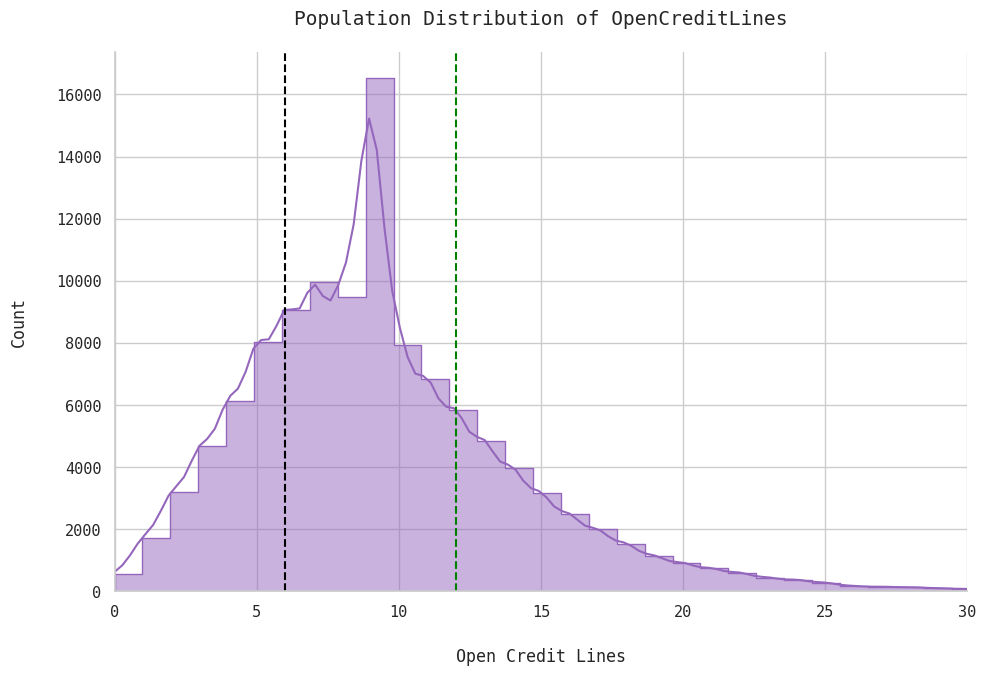

In [104]:
plt.figure(figsize=(11,7))
sns.histplot(data=score_charts, x='OpenCreditLines', color='tab:purple', element='step', kde=True, bins=55)
plt.title('Population Distribution of OpenCreditLines')
plt.xlabel('Open Credit Lines', labelpad=20)
plt.ylabel('Count', labelpad=20)
plt.xlim(0, 30)

q1rt = np.quantile(score_charts.OpenCreditLines, .25)
plt.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(score_charts.OpenCreditLines, .75)
plt.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

#### Open Credit Lines Insight
Mode is 10. There is a steeper rise compared to the fall indicating larger increases for each value in 1-10 compared to 10+. Abundant credit lines are rarer to see, such as 20.

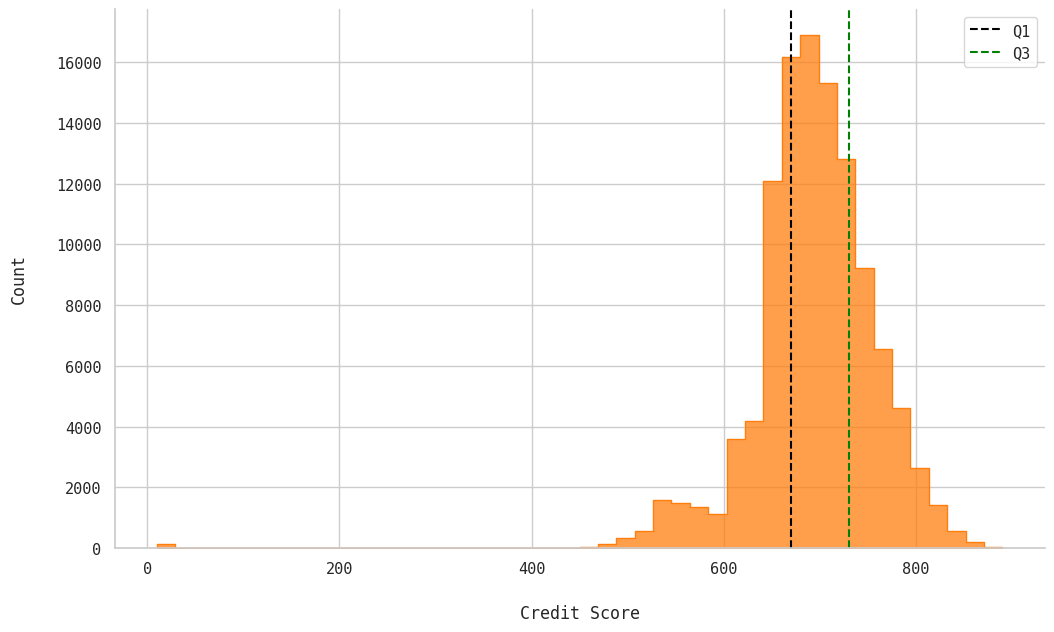

In [108]:
plt.figure(figsize=(12, 7))
sns.histplot(data=score_charts, x='CreditScore', bins=46, color='tab:orange', element='step')
plt.xlabel('Credit Score', labelpad=20)
plt.ylabel('Count', labelpad=20)
q1rt = np.quantile(score_charts['CreditScore'], .25)
plt.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(score_charts['CreditScore'], .75)
plt.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

plt.legend()
plt.show()

#### Credit Scores Insight
Left chart is lower score and right chart is upper score. Distribution is practically identical between these features. Mode appears to be ~700. Customer above ~700 should be provided with better conditions in order for Prosper to stay competitive with it's competition. Loans borrowers with higher credit scores are next-to guaranteed for fulfilling payments, so competition is fierce. Customers with a score of 400-599 should improve it to 600+ to receive average conditions.

### Bivariate Analysis
* Which ProsperScore has the closest No:Yes IncomeVerifiable ratio?
* Do higher amount delinquent and current delinquencies correlate to lower ProsperScores?
* Are open credit lines or total trades show positive correlation to ProsperScores?

Text(0.5, 0, 'ProsperScore')

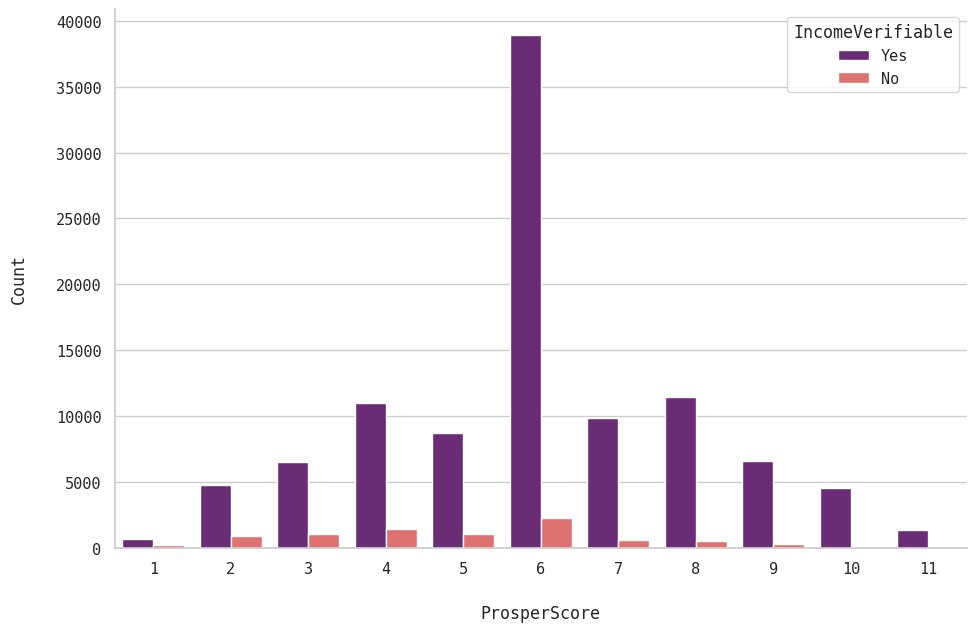

In [109]:
plt.figure(figsize=(11,7))
sns.countplot(data=score_charts, x='ProsperScore', hue='IncomeVerifiable', palette='magma')
plt.ylabel('Count', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

#### ProsperScore x IncomeVerifiable Insight
Higher ProsperScores on tend to have proportionally less "No" values on IncomeVerifiable. ProsperScore 1 value has closest Yes:No ratio. This confirms that proving Income will help in obtaining a better ProsperScore, and are therefor one step closer to improved loan conditions.

Text(0.5, 0, 'ProsperScore')

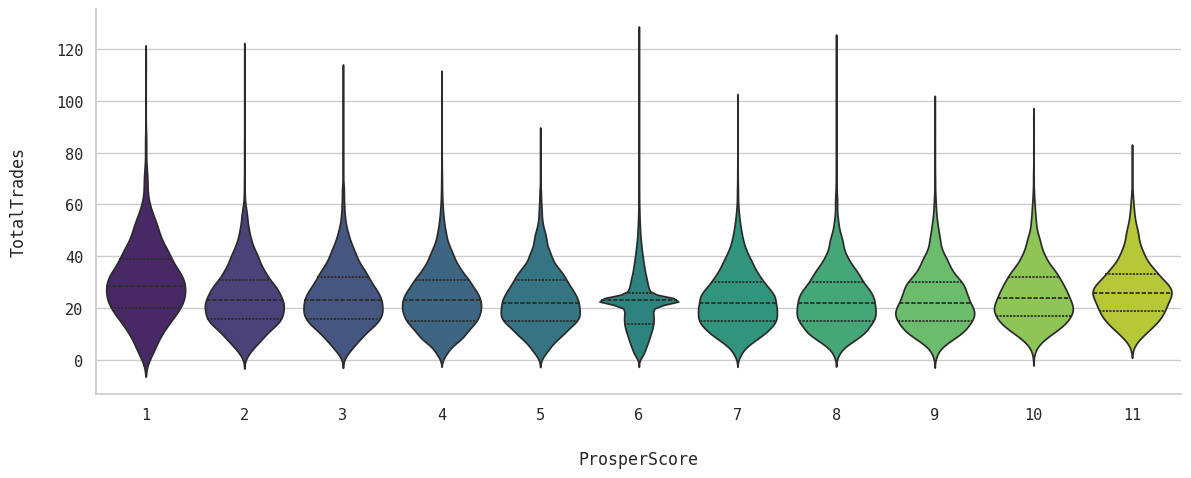

In [110]:
plt.figure(figsize=(14,5))
sns.violinplot(data=score_charts, x='ProsperScore', y='TotalTrades', inner='quartiles', palette='viridis')
plt.ylabel('TotalTrades', labelpad=20)
plt.xlabel("ProsperScore", labelpad=20)

#### ProsperScore x TotalTrades Insight
Value of 1, 2, 6, and 8 have the peak outliers. This indicates it's possible to get up to an 8 ProsperScore having ~120 total trades. Keep in mind, this does only extend to 8. Values 9+ peak at 100, with 11 peaking at 80. Customers need to limit their total trades to increase ProsperScore. Distributions are similar between all values besides 6 which is due to the imputes, and 1; ProsperScore 1 customers on average vary more in terms of TotalTrades. Low or no correlation between these features.

Text(0.5, 0, 'ProsperScore')

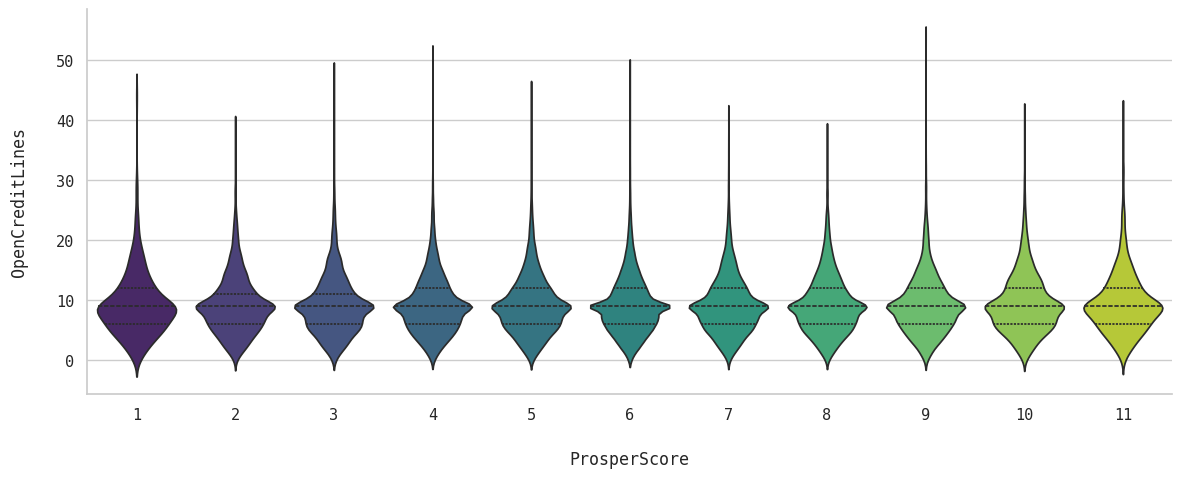

In [111]:
plt.figure(figsize=(14,5))
sns.violinplot(data=score_charts, x='ProsperScore', y='OpenCreditLines', inner='quartiles', palette='viridis')
plt.ylabel('OpenCreditLines', labelpad=20)
plt.xlabel("ProsperScore", labelpad=20)

#### ProsperScore x OpenCreditLines Insight
Distributions are almost identical between ProserScores. Only significant difference in this chart are the outliers. These 2 features can be concluded as having no correlation.

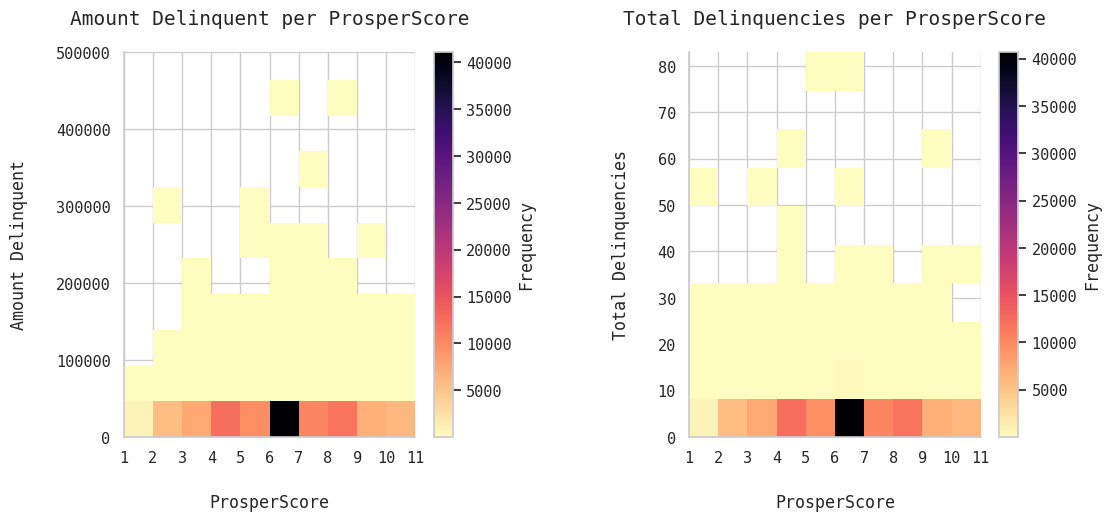

In [112]:
# Left chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
h1 = ax1.hist2d(data=score_charts, x='ProsperScore', y='AmountDelinquent', cmap='magma_r', cmin=1, bins=10)
ax1.set_title('Amount Delinquent per ProsperScore')
ax1.set_xlabel('ProsperScore', labelpad=20)
ax1.set_ylabel('Amount Delinquent', labelpad=20)
ax1.set_xticks([item for item in range(1, 12)])
ax1.set_ylim(0, 500000)
cbar1 = plt.colorbar(h1[3], ax=ax1)
cbar1.set_label('Frequency')

# Right chart
h2 = ax2.hist2d(data=score_charts, x='ProsperScore', y='CurrentDelinquents', cmap='magma_r', cmin=1, bins=10)
ax2.set_title('Total Delinquencies per ProsperScore')
ax2.set_xlabel('ProsperScore', labelpad=20)
ax2.set_ylabel('Total Delinquencies', labelpad=20)
ax2.set_xticks([item for item in range(1, 12)])
cbar2 = plt.colorbar(h2[3], ax=ax2)
cbar2.set_label('Frequency')

plt.subplots_adjust(wspace=.55)

#### Amount Delinquent x ProsperScore & Total Delinquencies x Prosper Score Insight
The left heatmap provides insight into the fact of nearly all customers maintaining a delinquent balance equal to or lower than 50,000. Outliers do exist above this figure. The middle ProsperScores of 4-8 have a higher population of customers with a 50,000 or less delinquent balance compared to others. Mode is ProsperScore 6 @ 50,000, max is ~450,000. The right heatmap shows similar distribution. The bottom tier, or 10, is applicable instead of 50,000. Mode is ProsperScore 6 @ 10, max is ~80. Similar amount of outliers for both heatmaps.
### Multivariate Analysis
* Are open credit lines and total trades proportiniate to each other for each ProsperScore?
* Which ProsperScores have the most concentrated values for open credit lines and total trades?
* Are "No" IncomeVerifiable values often delinquent or have higher delinquent balances than "Yes" values?

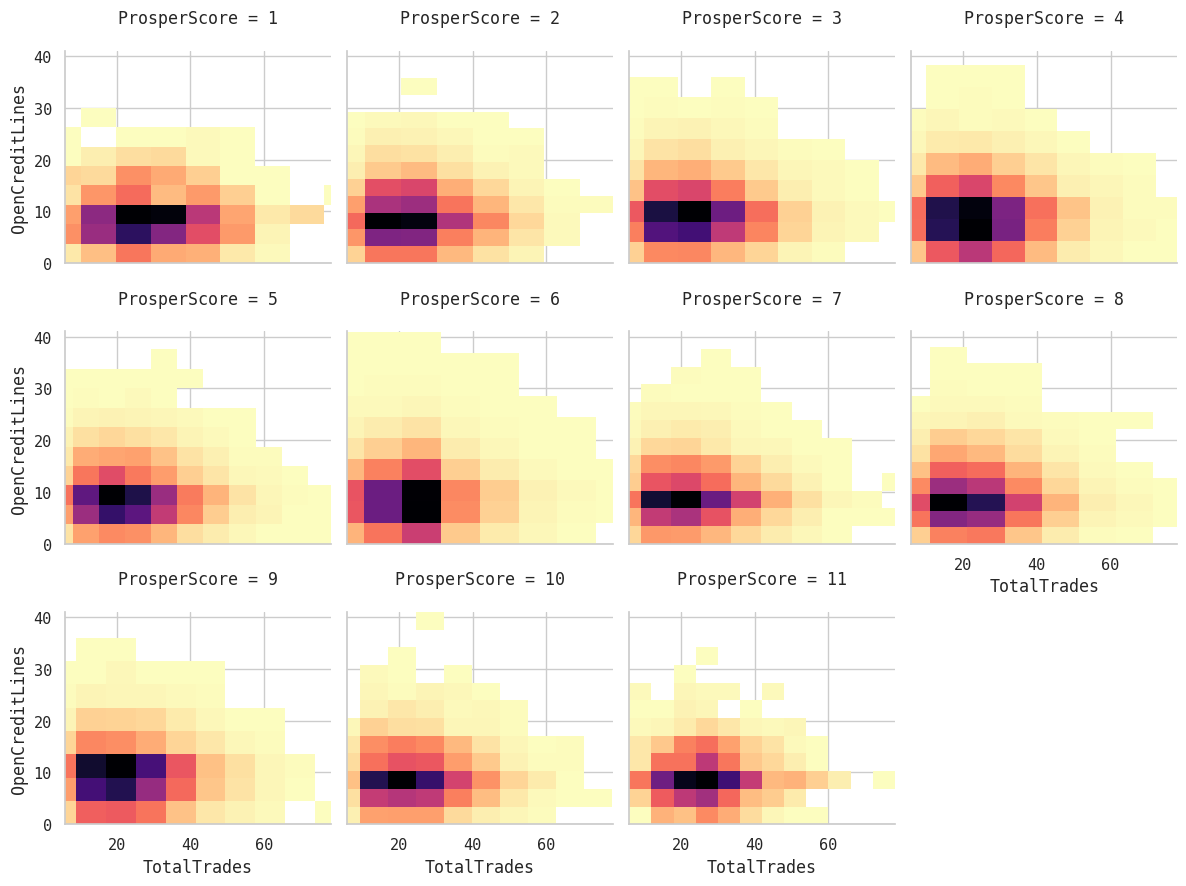

In [113]:
FG = sns.FacetGrid(data=score_charts, col='ProsperScore', col_wrap=4, height=3)
FG.map(plt.hist2d, 'TotalTrades', 'OpenCreditLines', cmap='magma_r', cmin=2, bins=12)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Total Trades x Open Credit Lines per ProsperScore Insight
Mode within all charts includes 20 Trades x 10 Credit lines. ProsperScores: 1, 2, 4, 6, 9, 11 have a split mode between 2 cells. Distribution for each ProsperScore, besides 6, has a radius of 2 cells where values gradually fade into lower amounts then dispersing into a large radius low yellow values. Customers who stick within the higher frequency radius will yield better loan conditions. Opening too many credit lines or trades is going against the status quo and could harm financial standing, according to Prosper and other loan providers. ProsperScore 4 & 6 have the least variance in values, contrasted by scores 10 & 11.

Text(0.5, 0, 'ProsperScore')

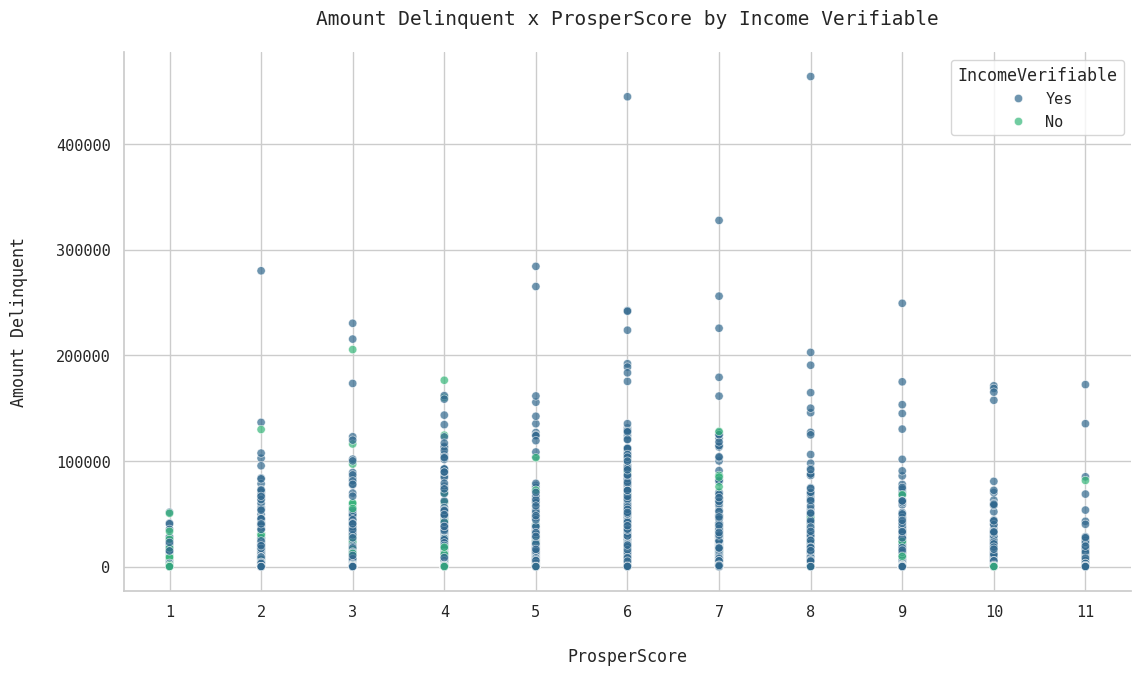

In [114]:
plt.figure(figsize=(13,7))
sns.scatterplot(data=score_charts, x='ProsperScore', y='AmountDelinquent', palette='viridis', hue='IncomeVerifiable',
               alpha=0.7)
plt.xticks([i for i in range(1,12)])
plt.title('Amount Delinquent x ProsperScore by Income Verifiable')
plt.ylabel('Amount Delinquent', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

Text(0.5, 0, 'ProsperScore')

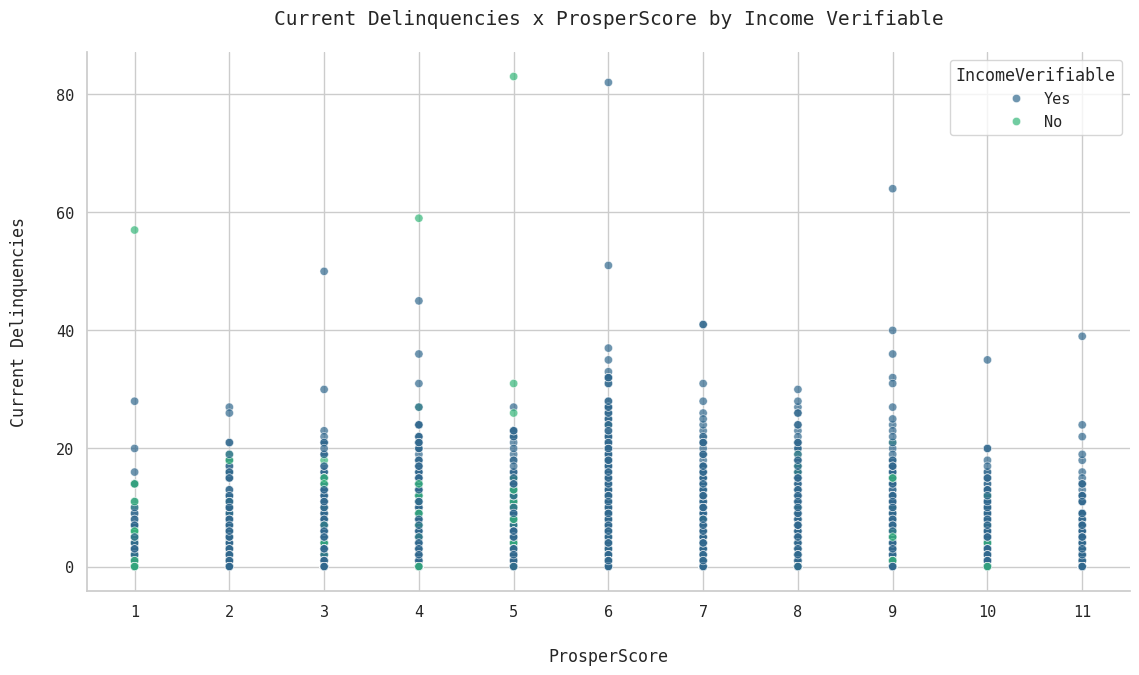

In [115]:
plt.figure(figsize=(13.45,7))
sns.scatterplot(data=score_charts, x='ProsperScore', y='CurrentDelinquents', palette='viridis', hue='IncomeVerifiable',
               alpha=0.7)
plt.xticks([i for i in range(1,12)])
plt.title('Current Delinquencies x ProsperScore by Income Verifiable')
plt.ylabel('Current Delinquencies', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

#### ProsperScore x CurrentDelinquents & ProsperScore x AmountDelinquent - by IncomeVerifiable Insight
"No" IncomeVarifiable values are prominently less common in categories 6+ in the bottom chart, and evenly dispersed in the top chart. ProsperScores 6, 7, 8, 10, 11 have scarce amounts or none of this value. Bottom chart outliers are equally dispersed between IncomeVerifiable, with the top chart dominated by "Yes" for this metric. Its possible Prosper does consider current delinquencies as more problematic than delinquent amount balance. It's advisable for customers to keep their current delinquencies in check. Having customers so embedded with debt such as 60+ current delinquences or 300,000 balance owed is a financial gamble. The safe play is to deny loan borrowers of this stature any new loans.

### Correlation Analysis

In [116]:
combine_pk = loan_df.index

# function to add PK's to each table for a merge
def table_join(x, y, z):
    table_list = [x.copy(), y.copy(), z.copy()]
    final_list = []
    for item in table_list:
        item['PK'] = combine_pk
        final_list.append(item)
    return final_list

combine_tables = table_join(loan_df, credit_df, customer_ML)

x_table = combine_tables[0]
y_table = combine_tables[1]
z_table = combine_tables[2]

mega_table = pd.merge(x_table, pd.merge(y_table, z_table, on='PK', how='outer'), on='PK', how='outer')

In [117]:
mega_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Term                        113066 non-null  int64  
 1   LoanStatus                  113066 non-null  object 
 2   BorrowerAPR                 113066 non-null  float64
 3   BorrowerRate                113066 non-null  float64
 4   ListingCategory (numeric)   113066 non-null  int64  
 5   LoanNumber                  113066 non-null  int64  
 6   LoanOriginalAmount          113066 non-null  int64  
 7   PK                          113066 non-null  int64  
 8   OpenCreditLines             113066 non-null  float64
 9   TotalCreditLinespast7years  113066 non-null  float64
 10  TotalInquiries              113066 non-null  float64
 11  CurrentDelinquencies        113066 non-null  float64
 12  AmountDelinquent            113066 non-null  float64
 13  BankcardUtiliz

In [118]:
# removing features with string values for correlation matrix
mega_table.drop(['LoanStatus', 'Occupation', 'EmploymentStatus', 'IncomeRange'], axis=1, inplace=True)

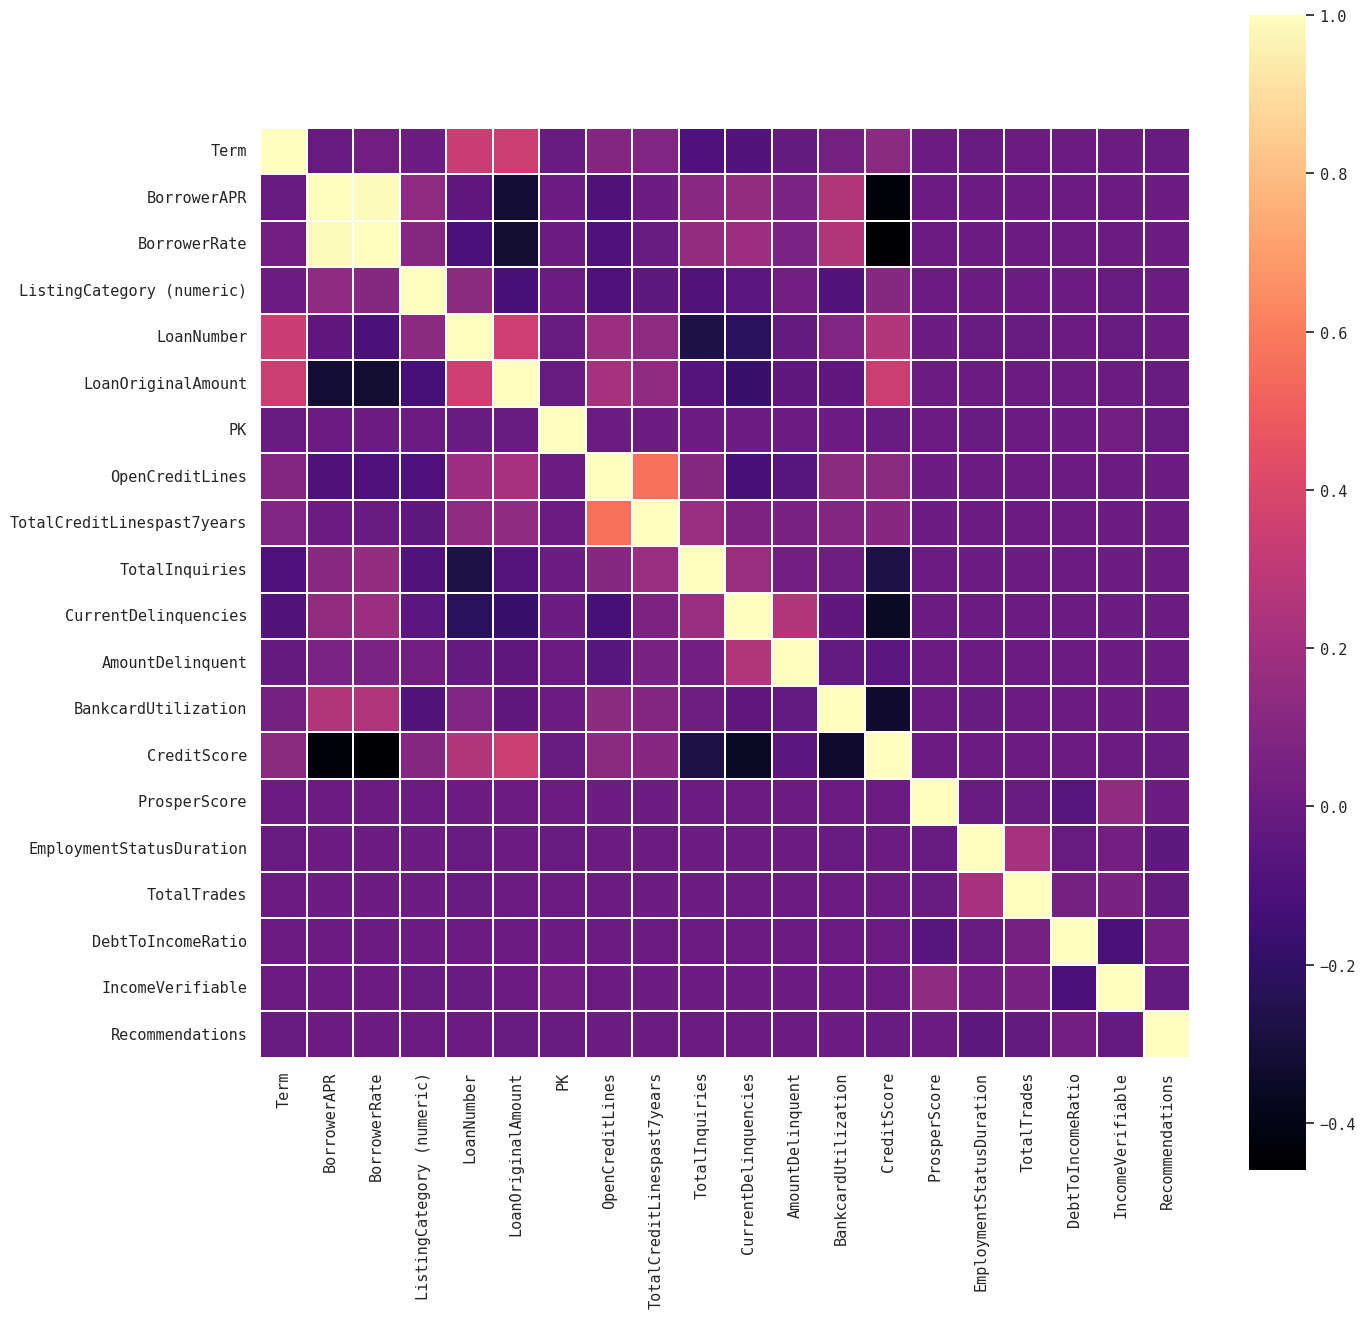

In [119]:
f, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(mega_table.corr(),linewidths=.2 ,square=True, cmap='magma')

It's evident that most variables do not have a relationship between each other, whether thats a negative or positive one. Of those relationships, the majority are positive correlations.
#### Negatives
The black squares and dark purples suggest a -.4 and -.2 r-value respectivelly. Loan Number, Loan Original Amount, Listing Category, Open Credit Lines, Total Inquiries, Current Delinquencies, Amount Delinquent, CreditScoreRangeLower & Upper, Bankcard Utilization, and Debt to Income Ratio are classified as having negative correlations. Most tend to float around -.2 r-value. There are 12 cells with the -.4 r-value. These are seen in the attributes of CreditScoreRangeLower & Upper, Loan Original Amount, APR, Rate, Total Inquiries, Current Delinquencies, and Bankcard Utilizaiton. 
#### Positives
The vanilla, orange, and pink are evident of positive relationships with r-values of 1, .6, and .4 respectivelly. BorrowerRate, BorrowerAPR, Loan Number, Loan Original Amount, CreditScoreRangeLower & Upper, Bankcard Utilization, Total Credit Lines past 7 years, and Current Delinquencies are classified as this type. A few of these also have polarized relationships with a different variable. 
#### Summary
Further analysis is required to formulate evidence of how exactly there variables influence each other, but the direction is clear. For the negatives, their higher or lower value causes the corresponding variable to respond oppositely. For the positives, their higher or lower values causes a similar response in the other variable. 